# FORECAST OF PRICE TRENDS OF VIETCOMBANK IN THE FUTURE

## IMPORT LIBRARIES

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
#Import some basic library 
import math
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
from datetime import datetime, timedelta

# Import some visualizing library 
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib import style
from matplotlib import ticker
import plotly.graph_objects as go
import seaborn as sns

# Import ARIMA library and Statistic library
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from scipy import stats
from itertools import product

# Import Extra Library
import warnings
warnings.filterwarnings('ignore')

## BASIC DATA 

In [19]:
# Load data by FinanceDataReader
df_raw = fdr.DataReader('VCB',exchange='HOSE') #VCB
df_raw.to_csv("VCB.csv")
df_raw

Close   Open   High    Low      Volume  Change
Date                                                      
2009-07-01  16524  17207  17207  16251  17960000.0  0.0084
2009-07-02  15841  16251  16387  15705   4360000.0 -0.0413
2009-07-03  15295  15431  15568  15295   2590000.0 -0.0345
2009-07-06  15978  15295  15978  15295   4520000.0  0.0447
2009-07-07  15431  15705  15841  15431   3210000.0 -0.0342
...           ...    ...    ...    ...         ...     ...
2022-06-16  79100  76700  80000  76500   1210000.0  0.0340
2022-06-17  76100  77000  78300  76100   1050000.0 -0.0379
2022-06-20  76000  79500  79500  75300   1090000.0 -0.0013
2022-06-21  77700  76000  77700  75200    937100.0  0.0224
2022-06-22  76000  77900  78000  75000   1070000.0 -0.0219

[3239 rows x 6 columns]

## RESAMPLE DATA ( COMPLETE DATA )

In [4]:
# by day 
d_df = pd.DataFrame(df_raw.loc[:, ['Close', 'Volume']], index=df_raw.index).resample('1d').mean().copy()

# Make a funtion that format again the data 
def New_Sort(df):
    df["NA"] = df["Close"].isna()
    for i in range(0,len(df)):
        if df["NA"][i] == True:
            df["Close"][i] =  df["Close"][i-1]
            df["Volume"][i] = 0
        else: 
            pass
    df.drop(["NA"],axis = 1)

New_Sort(d_df)

# by 1 week
w_df = d_df.resample('1w').mean().copy()

# by 2 week
bw_df = d_df.resample('2w').mean().copy()

# by month
m_df = d_df.resample('1M').mean().copy()

# get it into the list
df_list = [d_df, w_df, bw_df, m_df]

## A PRICE CHART 

In [5]:
def make_log_price_chart(df, frequency='Daily'):
    sns.set(style="ticks")
    fig_log_price = plt.figure(figsize=(20,10))
    # Make Frequence Variable 
    if 'Day' in str(df.index.freq):
        frequency = 'Daily'
    elif 'Week: weekday=6' in str(df.index.freq):
        frequency = 'Weekly'
    elif '2 * Weeks: weekday=6' in str(df.index.freq):
        frequency = '2-Weekly'
    elif 'MonthEnd' in str(df.index.freq):
        frequency = 'Monthly'
    
    # Make a plot size 
    ax1 = plt.subplot2grid((1, 1), (0, 0), rowspan=1, colspan=1)
    
    # Make a plot format
    ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%.2f'))
    ax1.yaxis.set_minor_formatter(ticker.FormatStrFormatter('$%.2f'))
    ax1.set_ylim([np.min(df_raw.Close) * 0.9, np.max(df_raw.Close) * 1.1])
    plt.ylabel('Price', fontsize=12)
    ax1.tick_params(axis='y', which='both', labelsize=8)
    plt.grid(which='minor')
    plt.xticks(fontsize=12, rotation=0)
    
    if 'forecast' in df.columns:    
        ax1.semilogy(df.index, df.Close, basey=10, color='#c92508', linewidth=0, marker='.')
        lg_price = mlines.Line2D([], [], color='#c92508', label="VCB's stock History Price", linewidth=0, marker='.')   
    else:
        ax1.semilogy(df.index, df.Close, basey=10, color='#c92508', linewidth=0.75)
        lg_price = mlines.Line2D([], [], color='#c92508', label="VCB's stock History Price", linewidth=1.5)
              
    if 'forecast' in df.columns:       
        # Make a plot 
        ax1.semilogy(df.index, df.forecast, basey=10, color='g', linewidth=0.75)
        # Make chart anotation
        bbox_props = dict(boxstyle='round',fc='g', ec='k',lw=0.25)
        last_forecast_price_date = df.forecast.last_valid_index()
        last_forecast_price_index = df.index.get_loc(last_forecast_price_date)
        last_forecast_price = df.forecast.iloc[last_forecast_price_index]
        ax1.annotate(str(last_forecast_price), (last_forecast_price_date, last_forecast_price),
                    xytext = (last_forecast_price_date + pd.Timedelta('7d'), last_forecast_price), 
                    bbox=bbox_props, fontsize=10)
        # Plot confidence interval
        first_forecast_price_date = df.forecast.first_valid_index()        
        first_forecast_price_index = df.index.get_loc(first_forecast_price_date)        
        ax1.fill_between(df.index[first_forecast_price_index:], 
                         df['upper forecast'].iloc[first_forecast_price_index:], 
                         df['lower forecast'].iloc[first_forecast_price_index:], 
                         color='r', 
                         alpha=0.2)
        # Make a format
        ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%.2f'))
        ax1.yaxis.set_minor_formatter(ticker.FormatStrFormatter('$%.2f'))
        # Make a legend 
        lg_forecast = mlines.Line2D([], [], color='g', label="VCB's stock Forecast", linewidth=1.5)
        lg_forecast_ci = mpatches.Patch(color='r', label='95% Confidence Interval', alpha=0.2)
        plt.legend(handles=[lg_price, lg_forecast, lg_forecast_ci], loc='center right')
    else:
        bbox_props = dict(boxstyle='round',fc='w', ec='k', lw=0.25)
        last_known_price_date = df.Close.last_valid_index()
        last_known_price_index = df.index.get_loc(last_known_price_date)
        last_known_price = df.Close.iloc[last_known_price_index]
        ax1.annotate(str(last_known_price), (last_known_price_date, last_known_price),
                    xytext = (last_known_price_date + pd.Timedelta('14d'), last_known_price), 
                    bbox=bbox_props, fontsize=10)
        plt.legend(handles=[lg_price], loc='center right')       

    title = "VCB's stock {} Price".format(frequency)
    plt.title(title, fontsize=16)     
    plt.savefig('images {}'.format(frequency))
    plt.show()

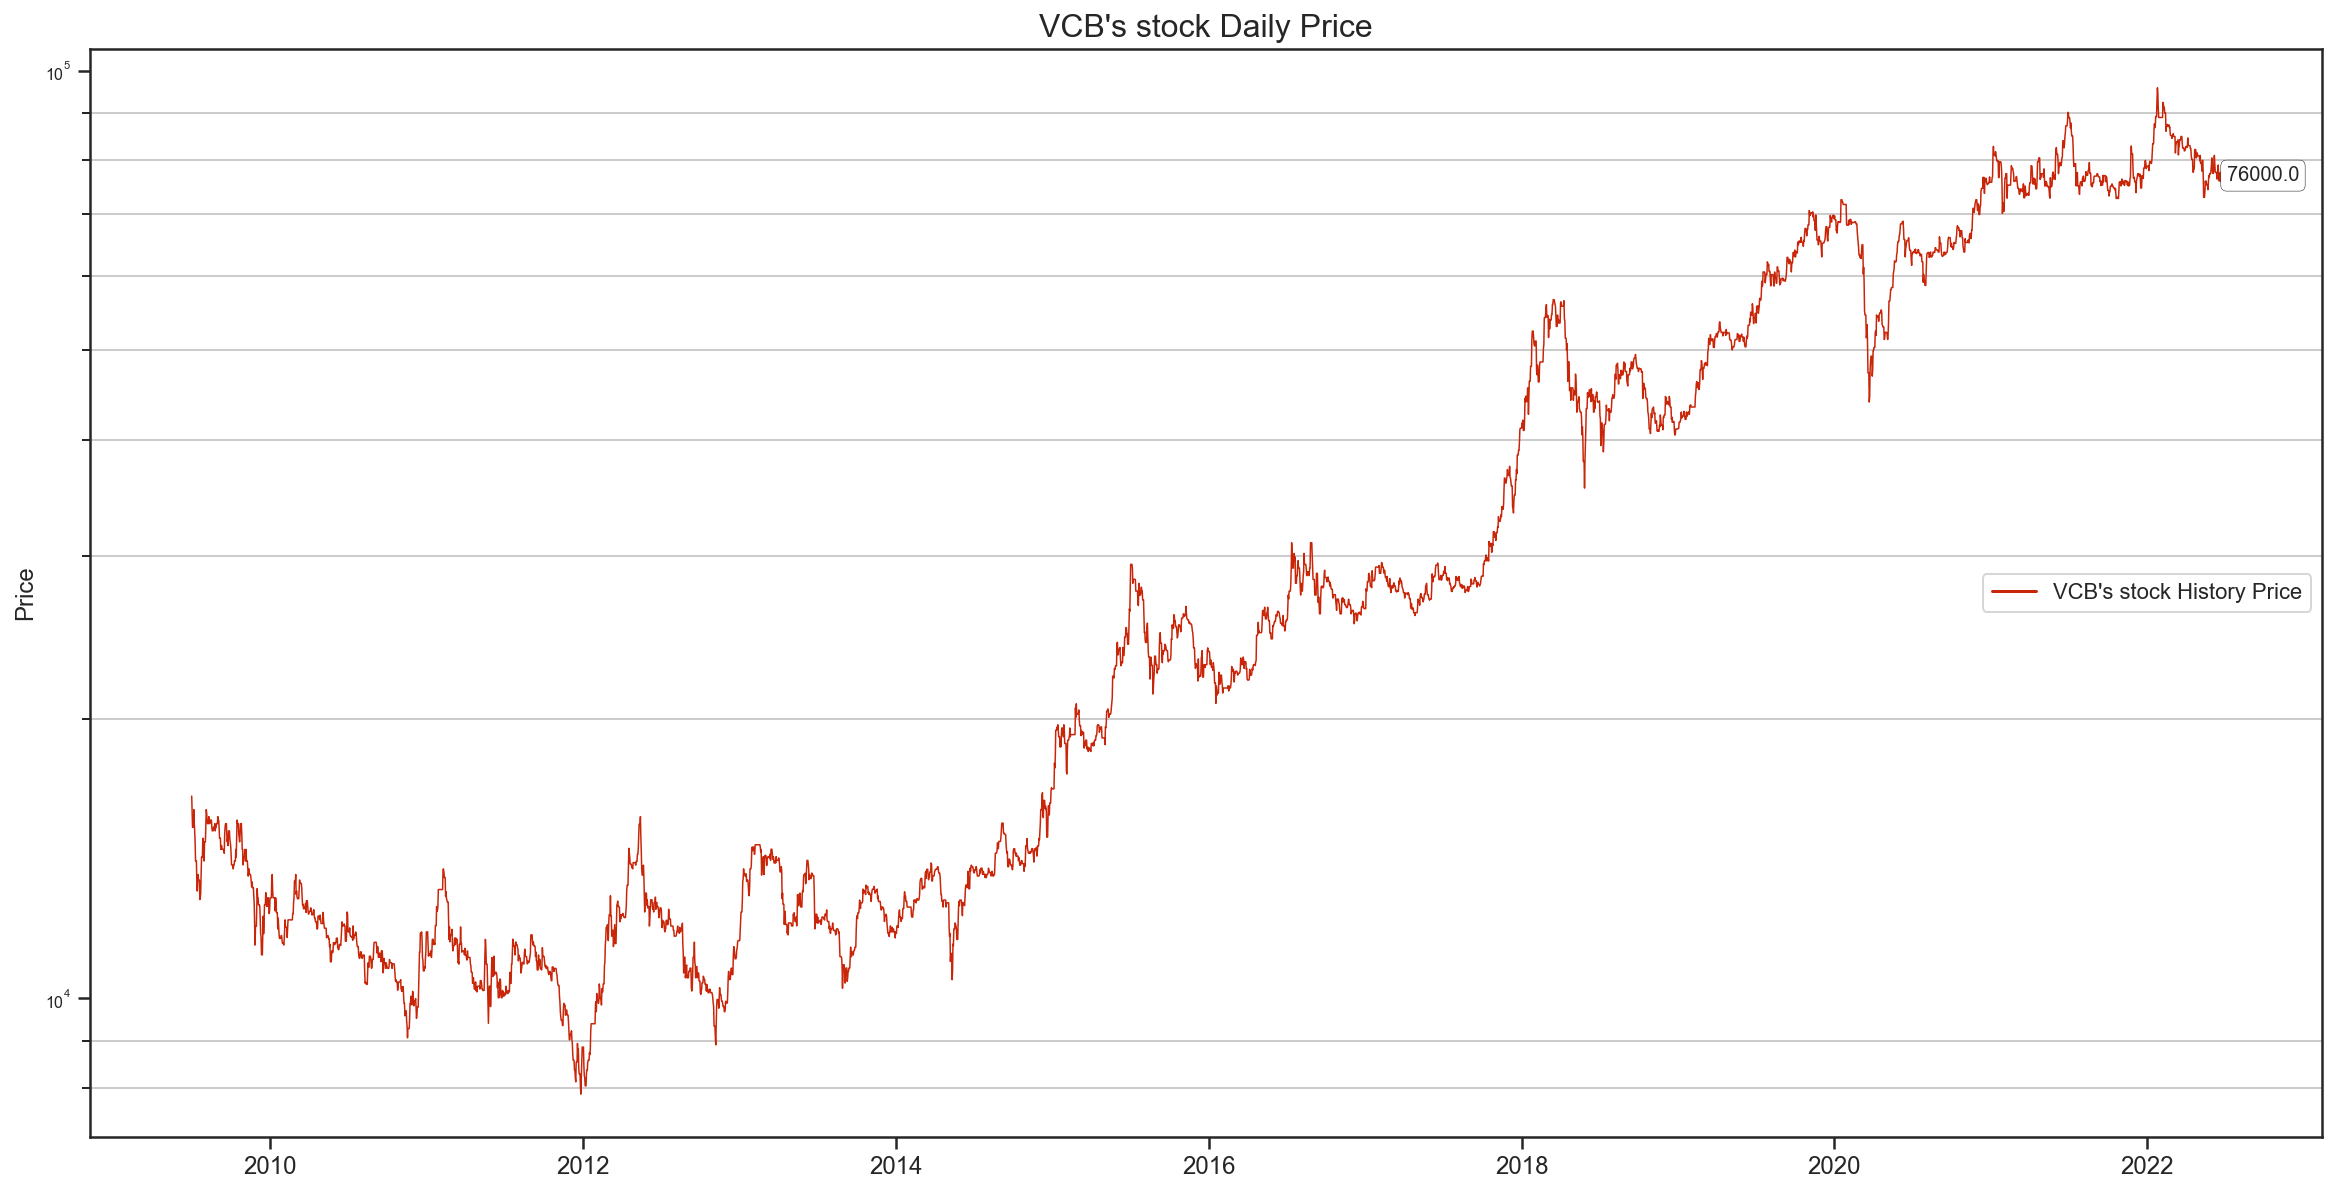

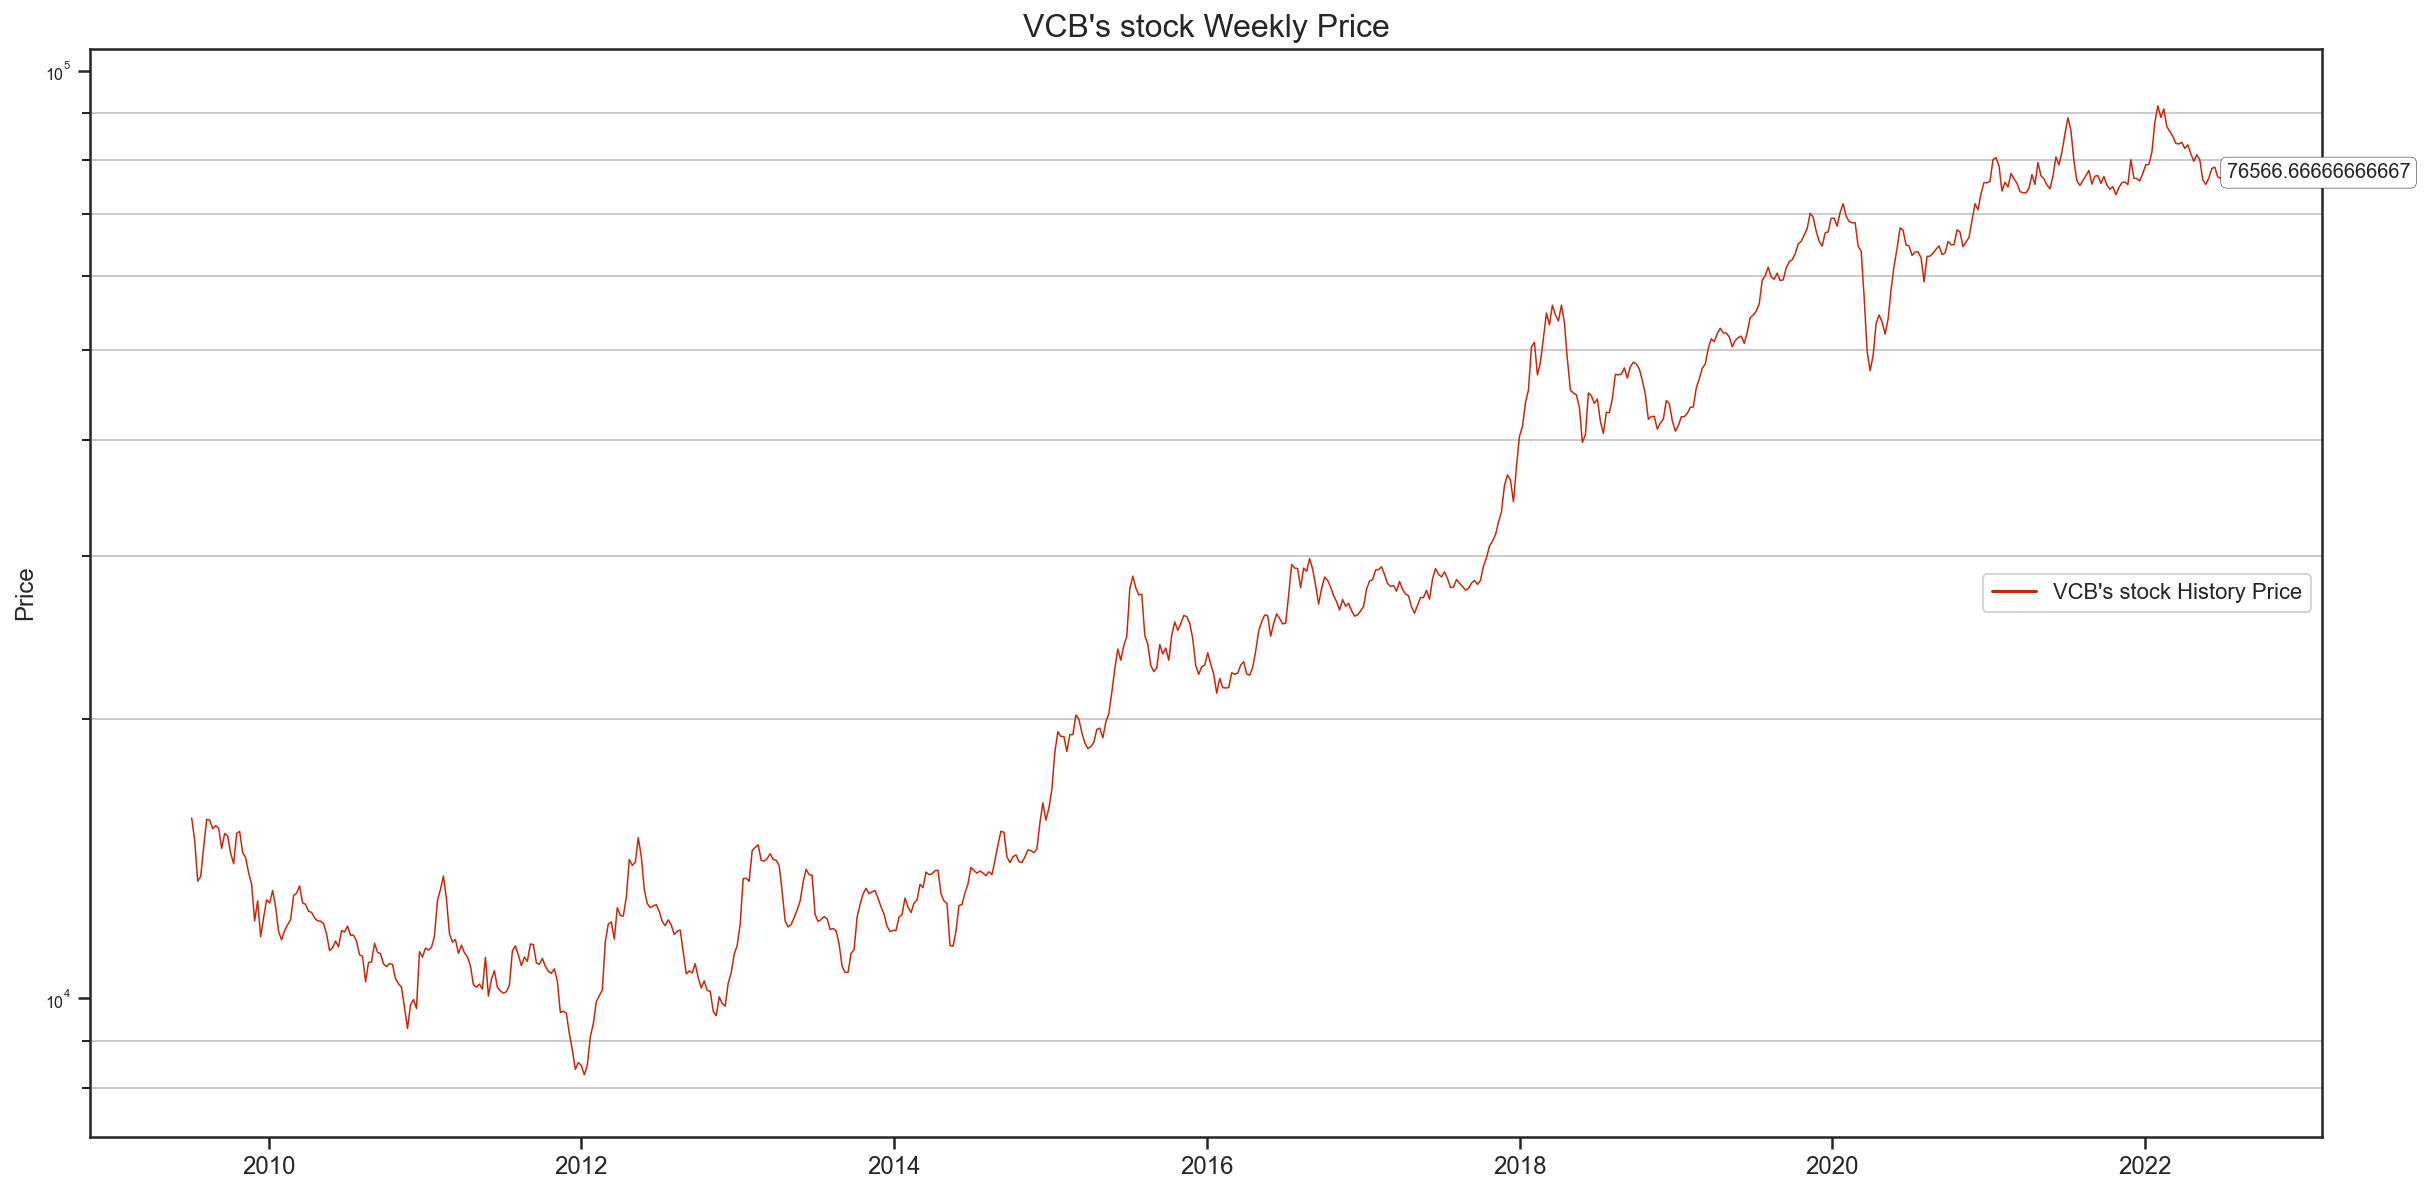

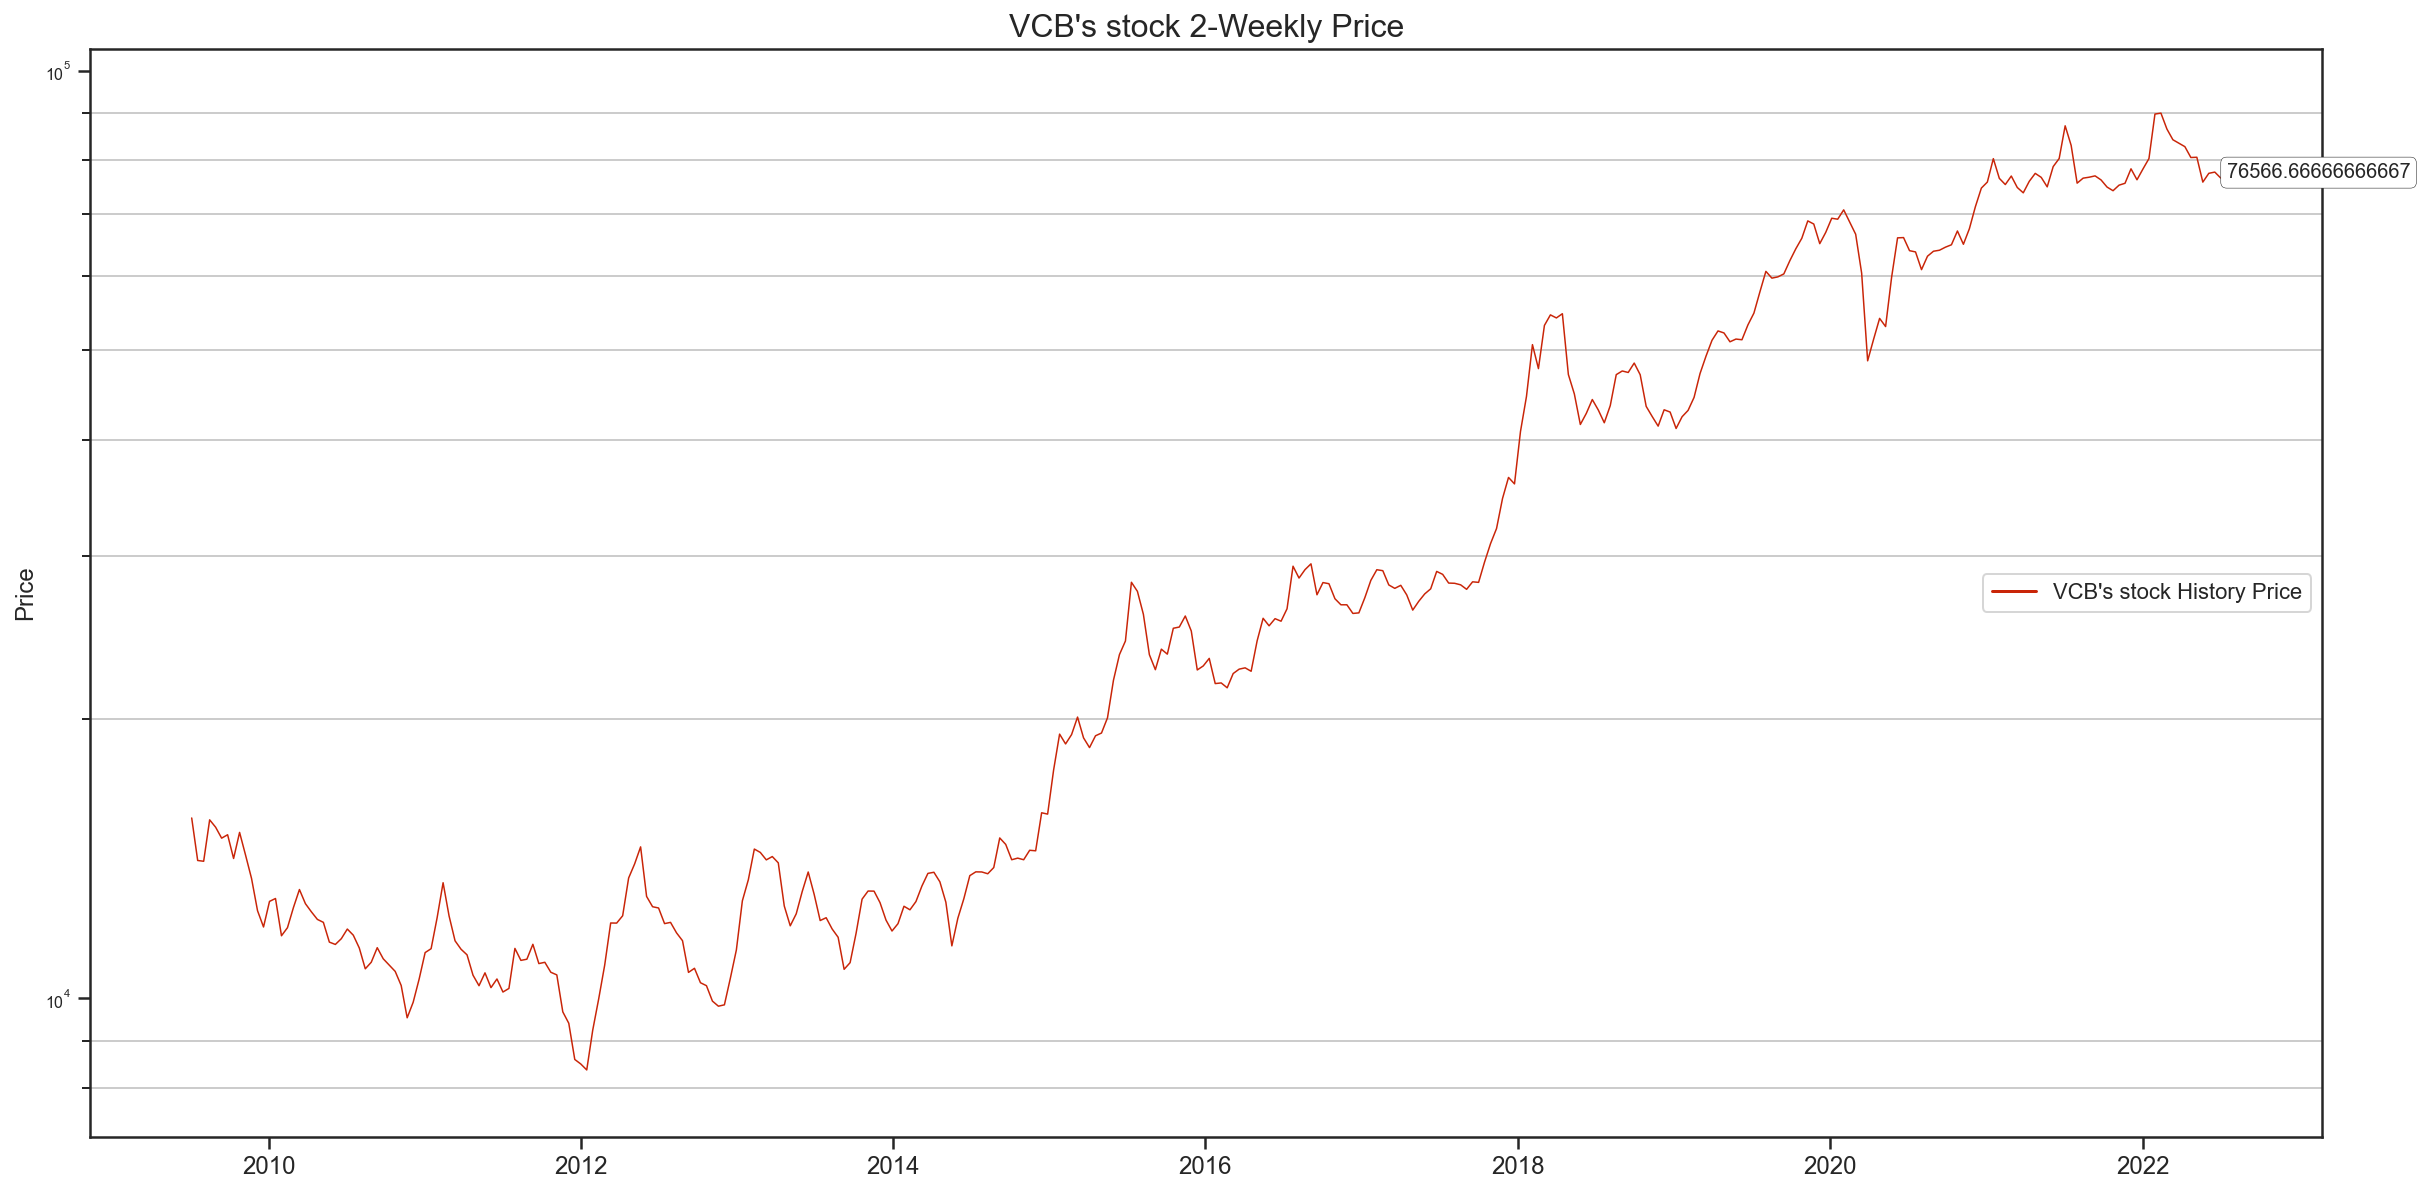

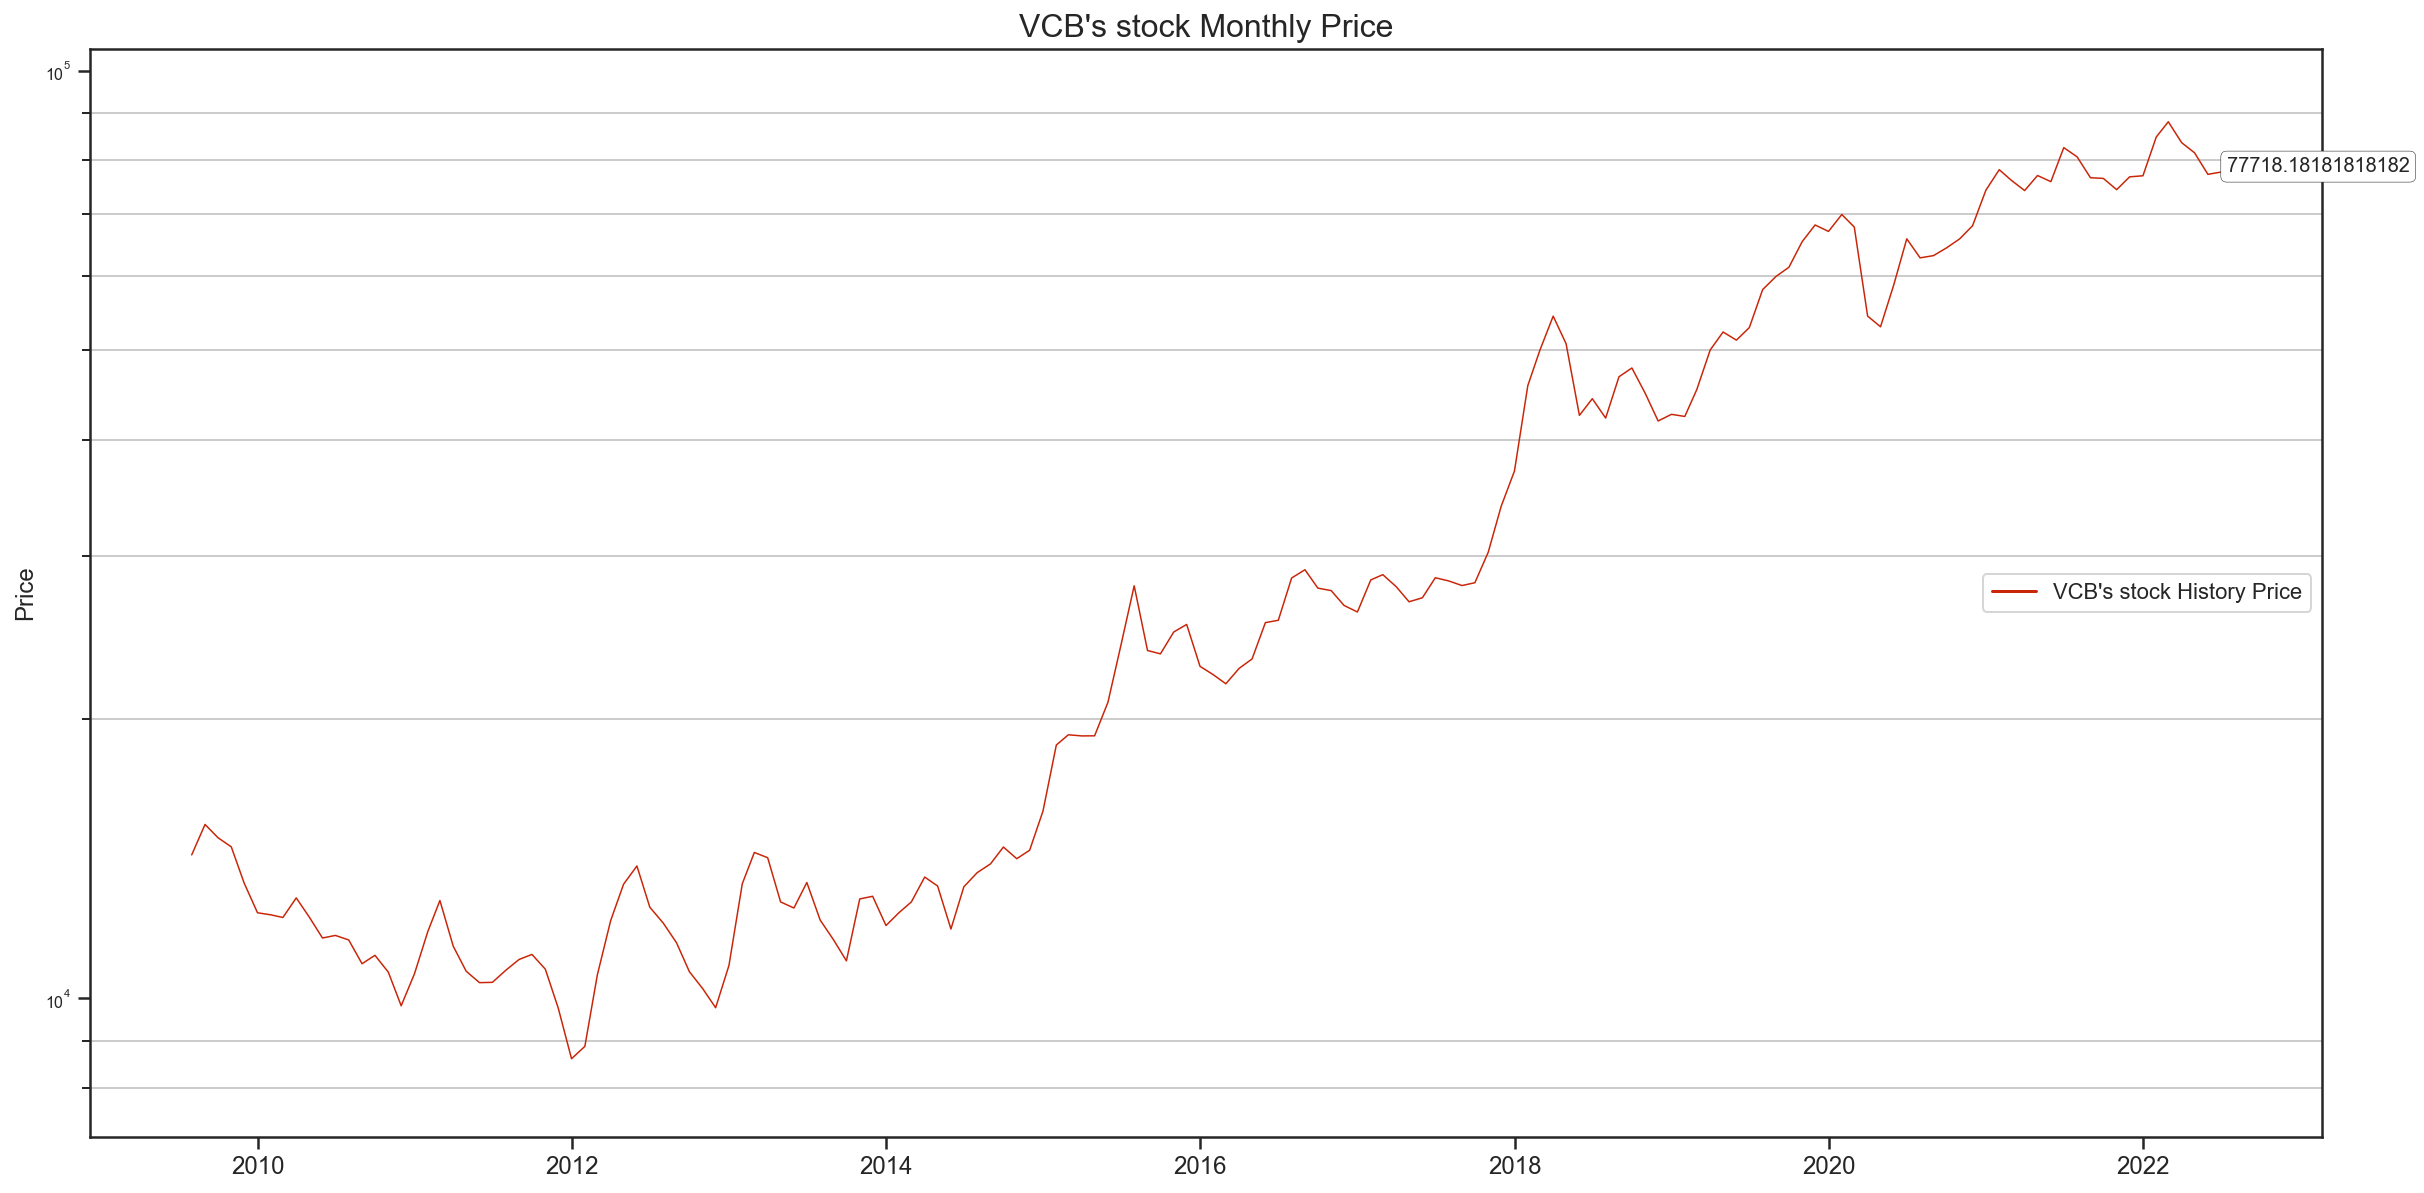

In [6]:
for df in df_list:
    make_log_price_chart(df)

## STATIONARITY TEST  

In [7]:
def run_stationarity_test(time_series, window=20):
    sns.set(style="darkgrid")
    # Make rolling staictis data
    rolmean = time_series.rolling(window=window).mean()
    rolstd = time_series.rolling(window=window).std()
    rolstd = rolstd.dropna()
    rolmean = rolmean.dropna()
    # Make a plot for rolling staictis data
    fig = plt.figure(figsize=(27, 6))
    orig = plt.semilogy(time_series, color='blue',label='Original', lw=0.75, alpha=0.7)
    mean = plt.semilogy(rolmean, color='red', label='Rolling Mean', lw=1)
    std = plt.semilogy(rolstd, color='black', label = 'Rolling Std', lw=1)
    plt.legend(loc='best')
    
    if 'Day' in str(time_series.index.freq):
        freq = 'Daily'
    elif 'Week: weekday=6' in str(time_series.index.freq):
        freq = 'Weekly'
    elif '2 * Weeks: weekday=6' in str(time_series.index.freq):
        freq = '2-Weekly'
    elif 'MonthEnd' in str(time_series.index.freq):
        freq = 'Monthly'
    
    plt.title('{} Data Rolling Mean & Standard Deviation'.format(freq), fontsize=20)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14, rotation=0)
    plt.savefig('images {} Data Rolling Mean & Standard Deviation'.format(freq))
    plt.show()  
    
    # Run ADF Test 
    print('Results of ADF Test:')
    dftest = adfuller(time_series.dropna(), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
  

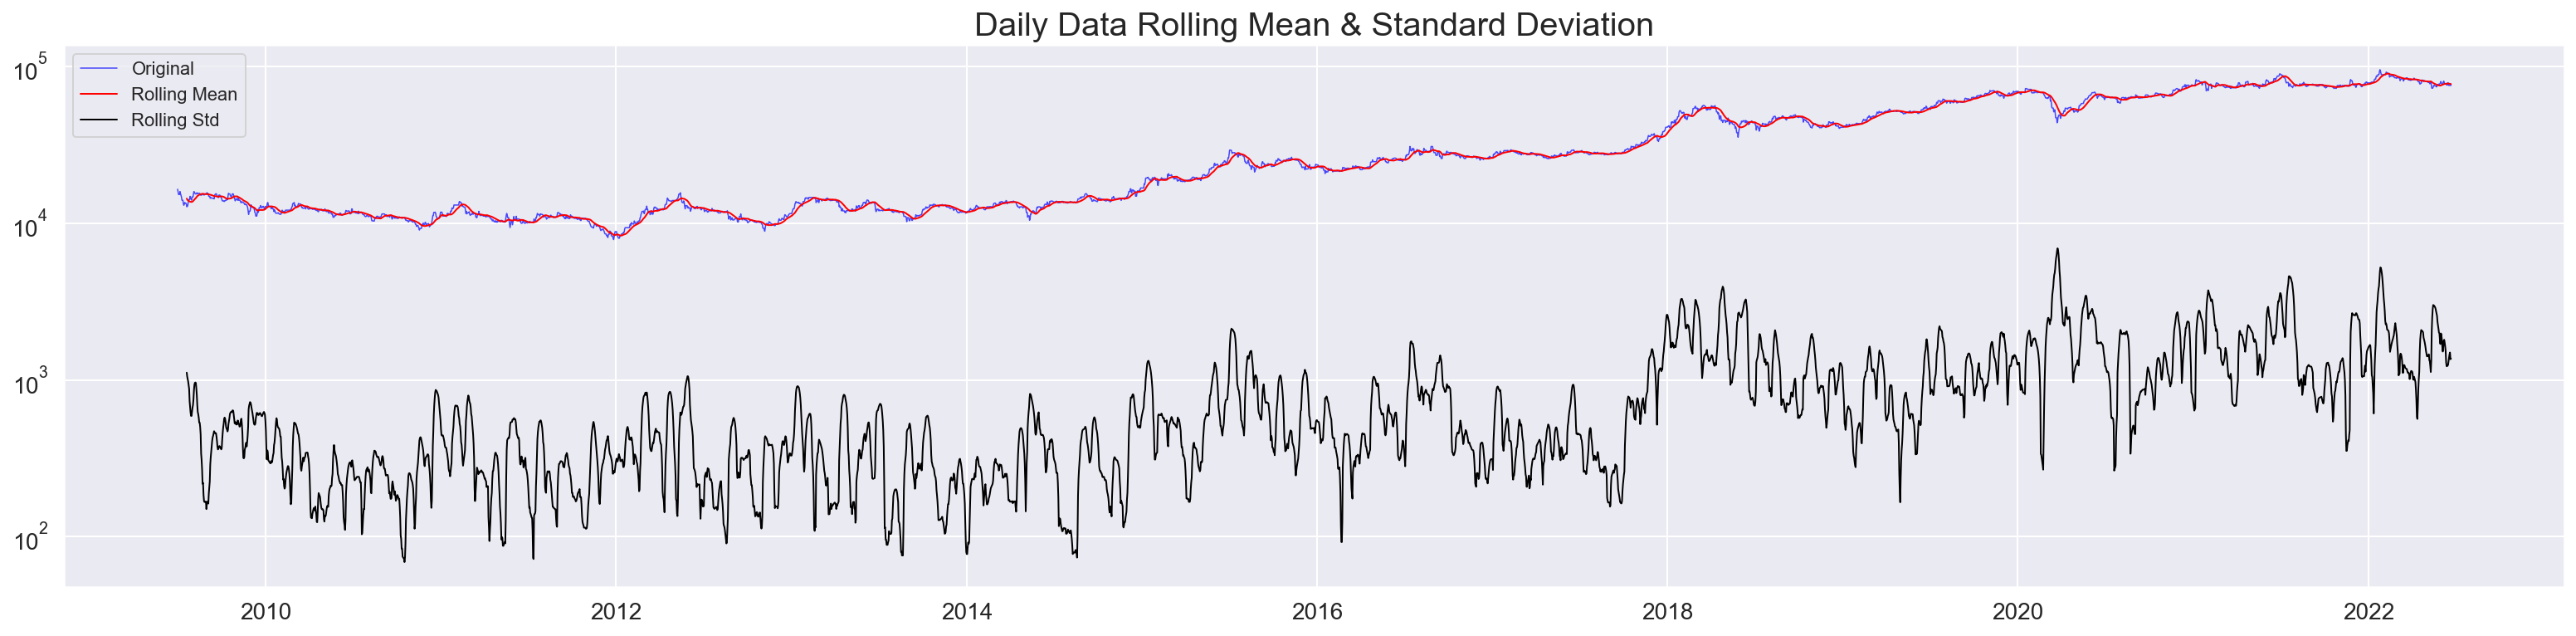

Results of ADF Test:
Test Statistic                   -0.119518
p-value                           0.947459
#Lags Used                       11.000000
Number of Observations Used    4728.000000
Critical Value (1%)              -3.431734
Critical Value (5%)              -2.862152
Critical Value (10%)             -2.567096
dtype: float64


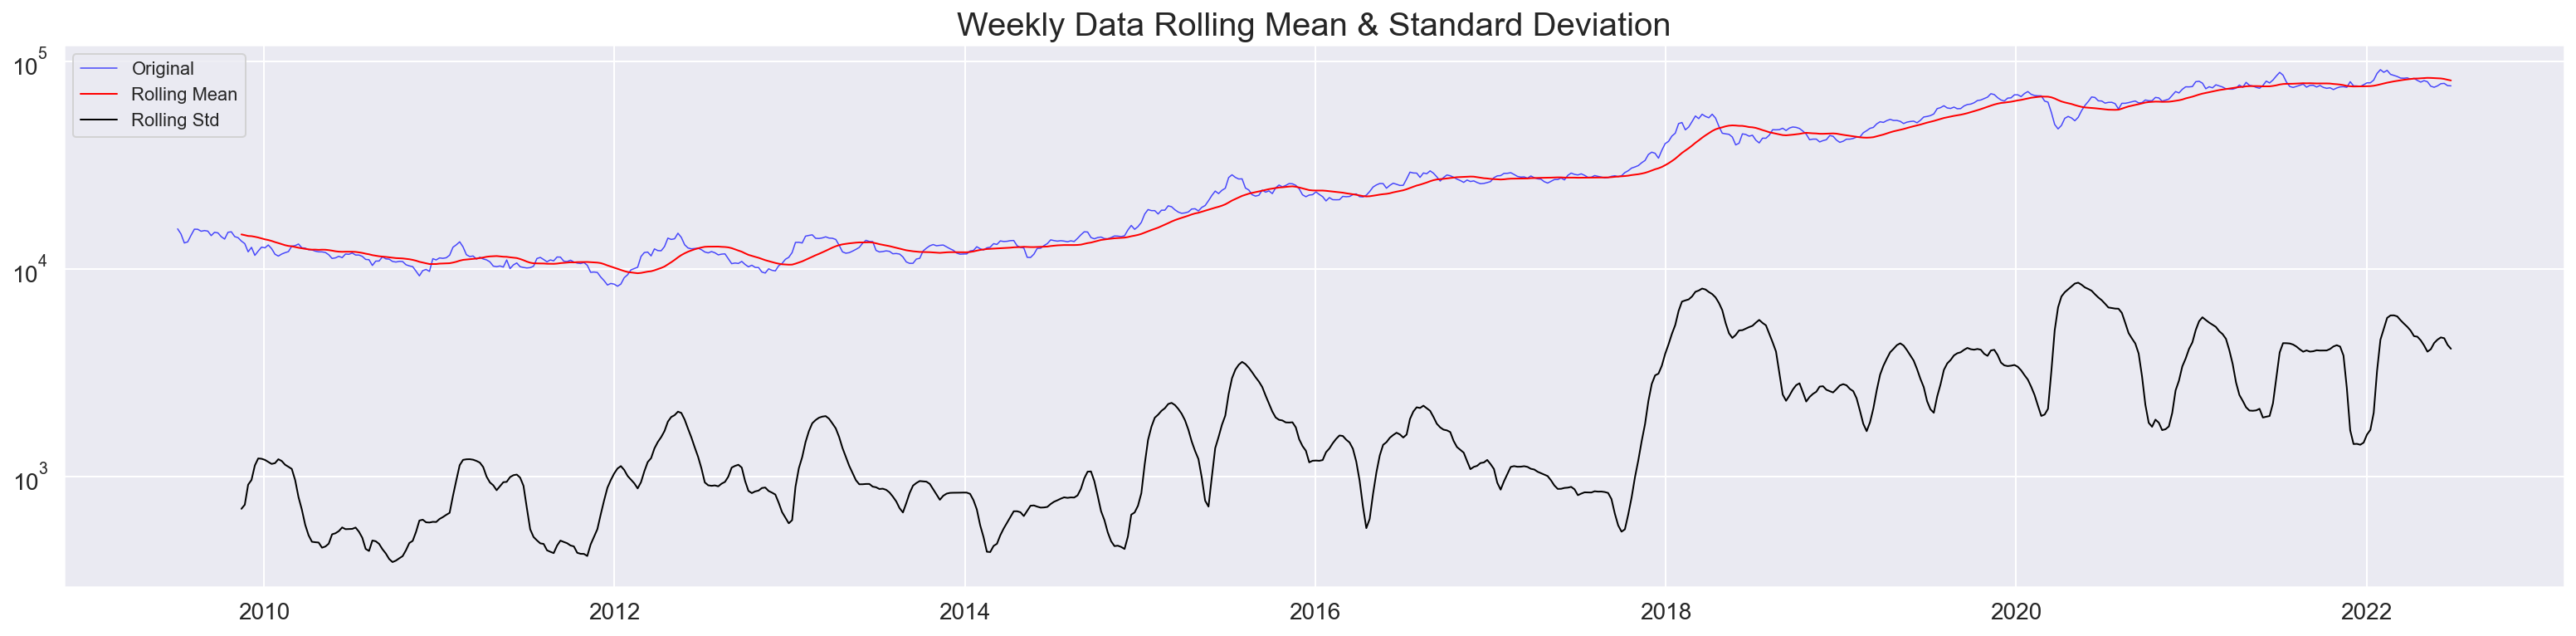

Results of ADF Test:
Test Statistic                   0.692109
p-value                          0.989679
#Lags Used                      20.000000
Number of Observations Used    657.000000
Critical Value (1%)             -3.440342
Critical Value (5%)             -2.865949
Critical Value (10%)            -2.569118
dtype: float64


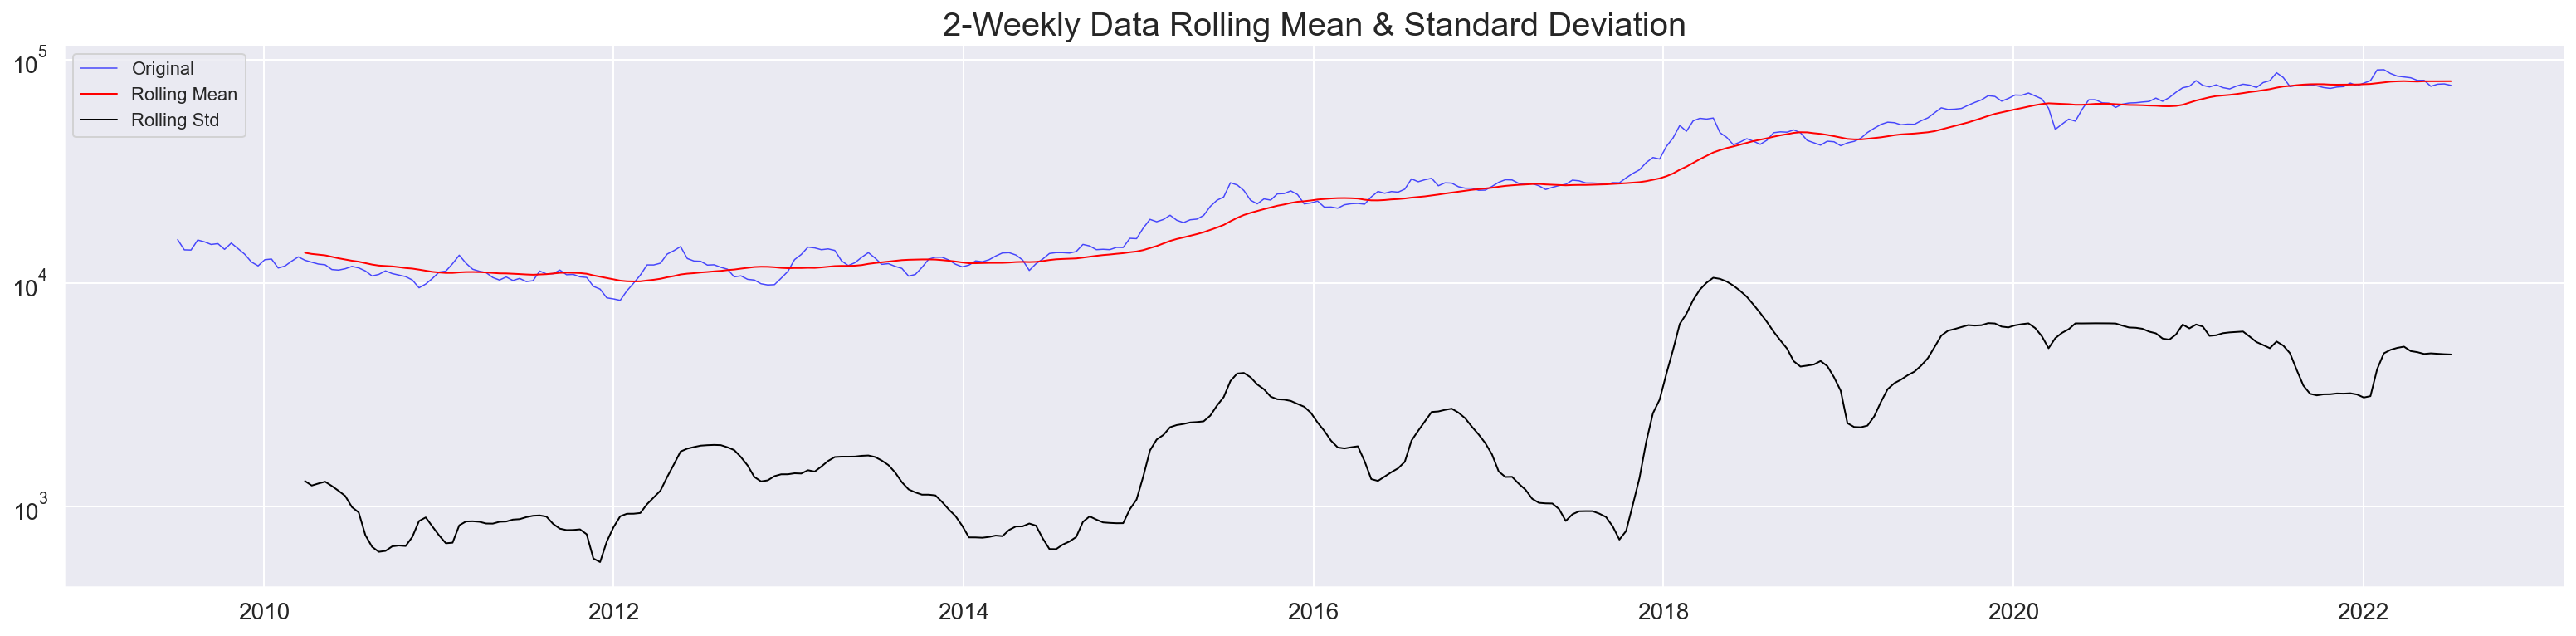

Results of ADF Test:
Test Statistic                  -0.121643
p-value                          0.947240
#Lags Used                       1.000000
Number of Observations Used    338.000000
Critical Value (1%)             -3.449846
Critical Value (5%)             -2.870129
Critical Value (10%)            -2.571346
dtype: float64


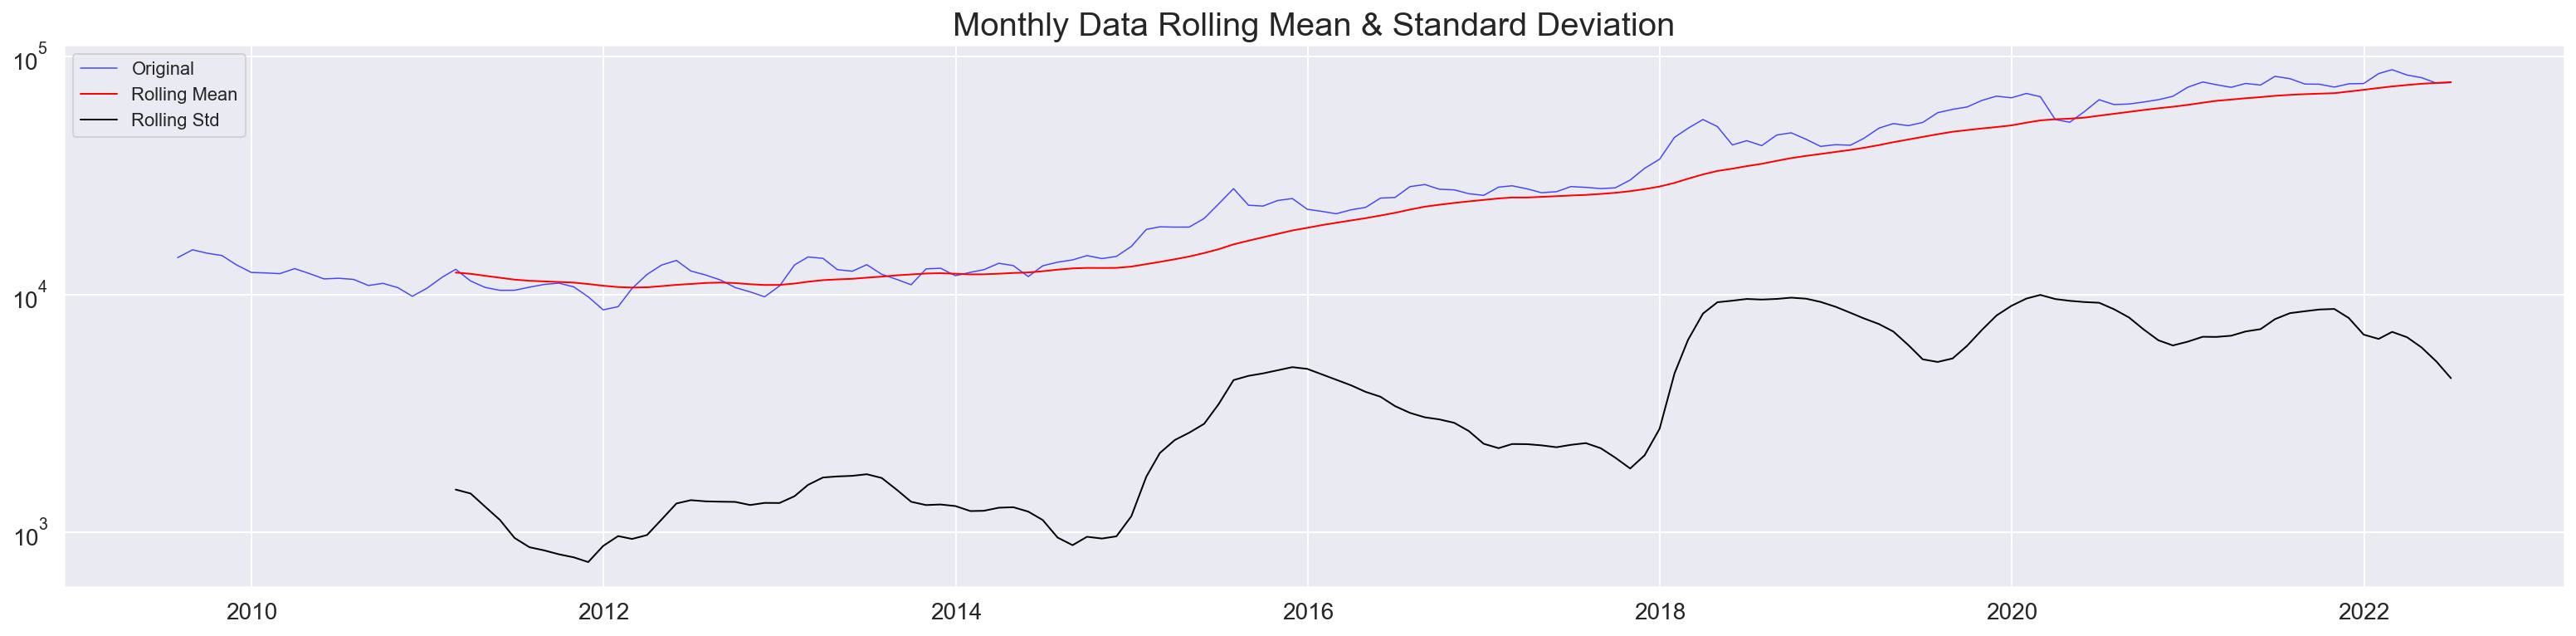

Results of ADF Test:
Test Statistic                   1.942677
p-value                          0.998594
#Lags Used                      11.000000
Number of Observations Used    144.000000
Critical Value (1%)             -3.476598
Critical Value (5%)             -2.881829
Critical Value (10%)            -2.577589
dtype: float64


In [8]:
for df in df_list:
    run_stationarity_test(df.Close)

## THE BOX BOX TRANSFORMATION

In [9]:
def run_box_cox(pd_dataframe):
    if 'Day' in str(pd_dataframe.index.freq):
        freq = 'Daily'
    elif 'Week: weekday=6' in str(pd_dataframe.index.freq):
        freq = 'Weekly'
    elif '2 * Weeks: weekday=6' in str(pd_dataframe.index.freq):
        freq = '2-Weekly'
    elif 'MonthEnd' in str(pd_dataframe.index.freq):
        freq = 'Monthly'

    sns.set(style="darkgrid")
    f, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=False)   
    
    ax1 = axes[0, 0]    
    prob = stats.probplot(pd_dataframe['Close'], dist=stats.norm, plot=ax1, fit=False)    
    ax1.set_title('Probability Plot Before Transformation')
        
    ax2 = axes[0, 1]
    box_cox, lmbda = stats.boxcox(pd_dataframe['Close'])
    pd_dataframe['price_box'] = pd.Series(box_cox, index=pd_dataframe.index)
    pd_dataframe['lmbda'] = lmbda
    prob = stats.probplot(box_cox, dist=stats.norm, plot=ax2, fit=False)
    ax2.set_title('Probability Plot After Transformation')    
    
    ax3 = axes[1, 0]
    sns.kdeplot(pd_dataframe['Close'], shade=True, ax=ax3, label='KDE Price')
    ax3.set_title('KDE Plot Before Transformation')
    
    ax4 = axes[1, 1]
    sns.kdeplot(box_cox, shade=True, ax=ax4, label='KDE Price Box', color='r')
    ax4.set_title('KDE Plot After Transformation')
    
    f.suptitle("VCB's stock {} Price Box-Cox Transformation".format(freq), fontsize=16)
    f.subplots_adjust(top=0.91, hspace=0.3)

    plt.savefig('images {} Price Box-Cox Transformation'.format(freq))
    plt.show()
 

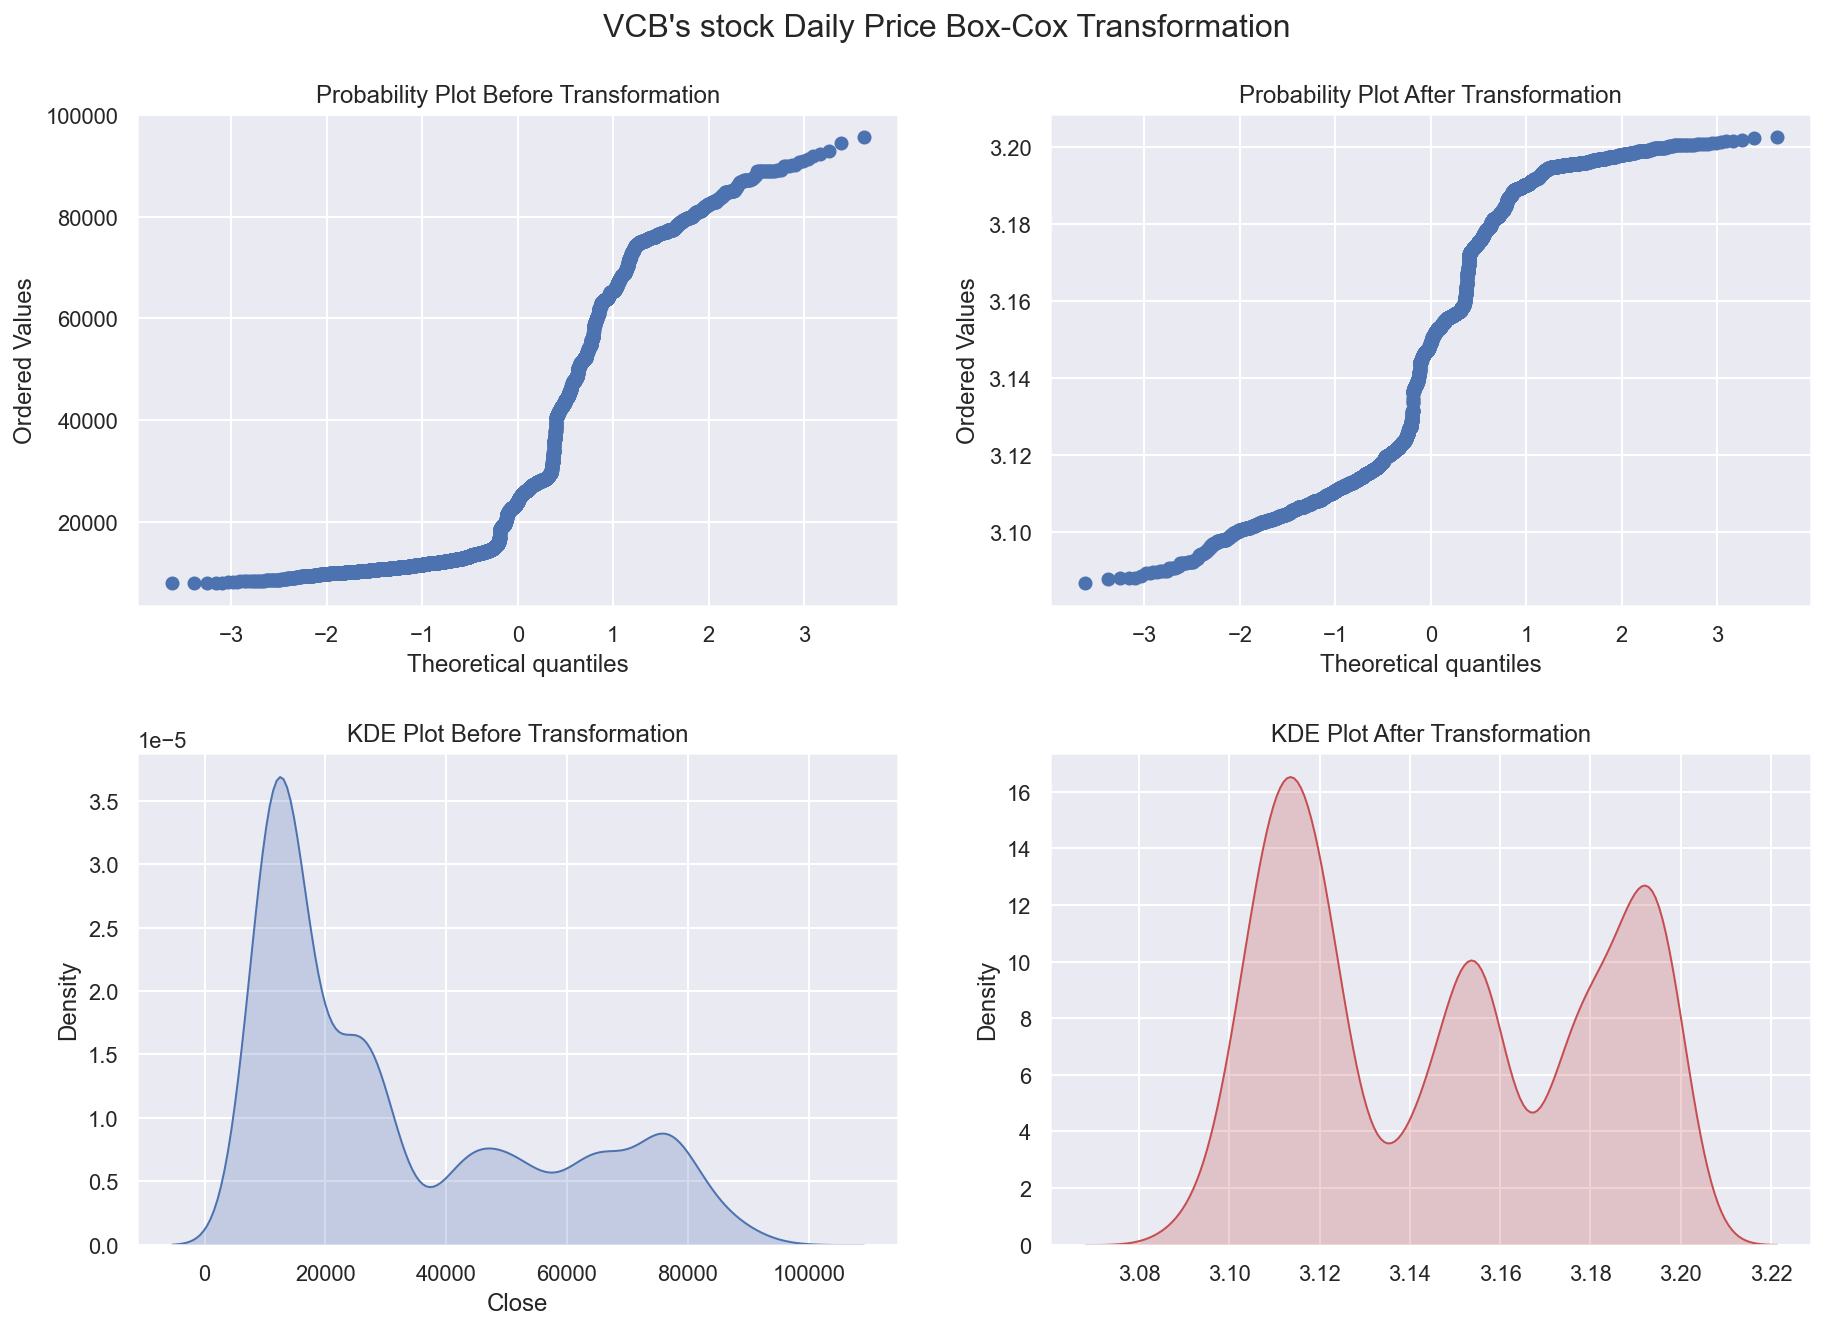

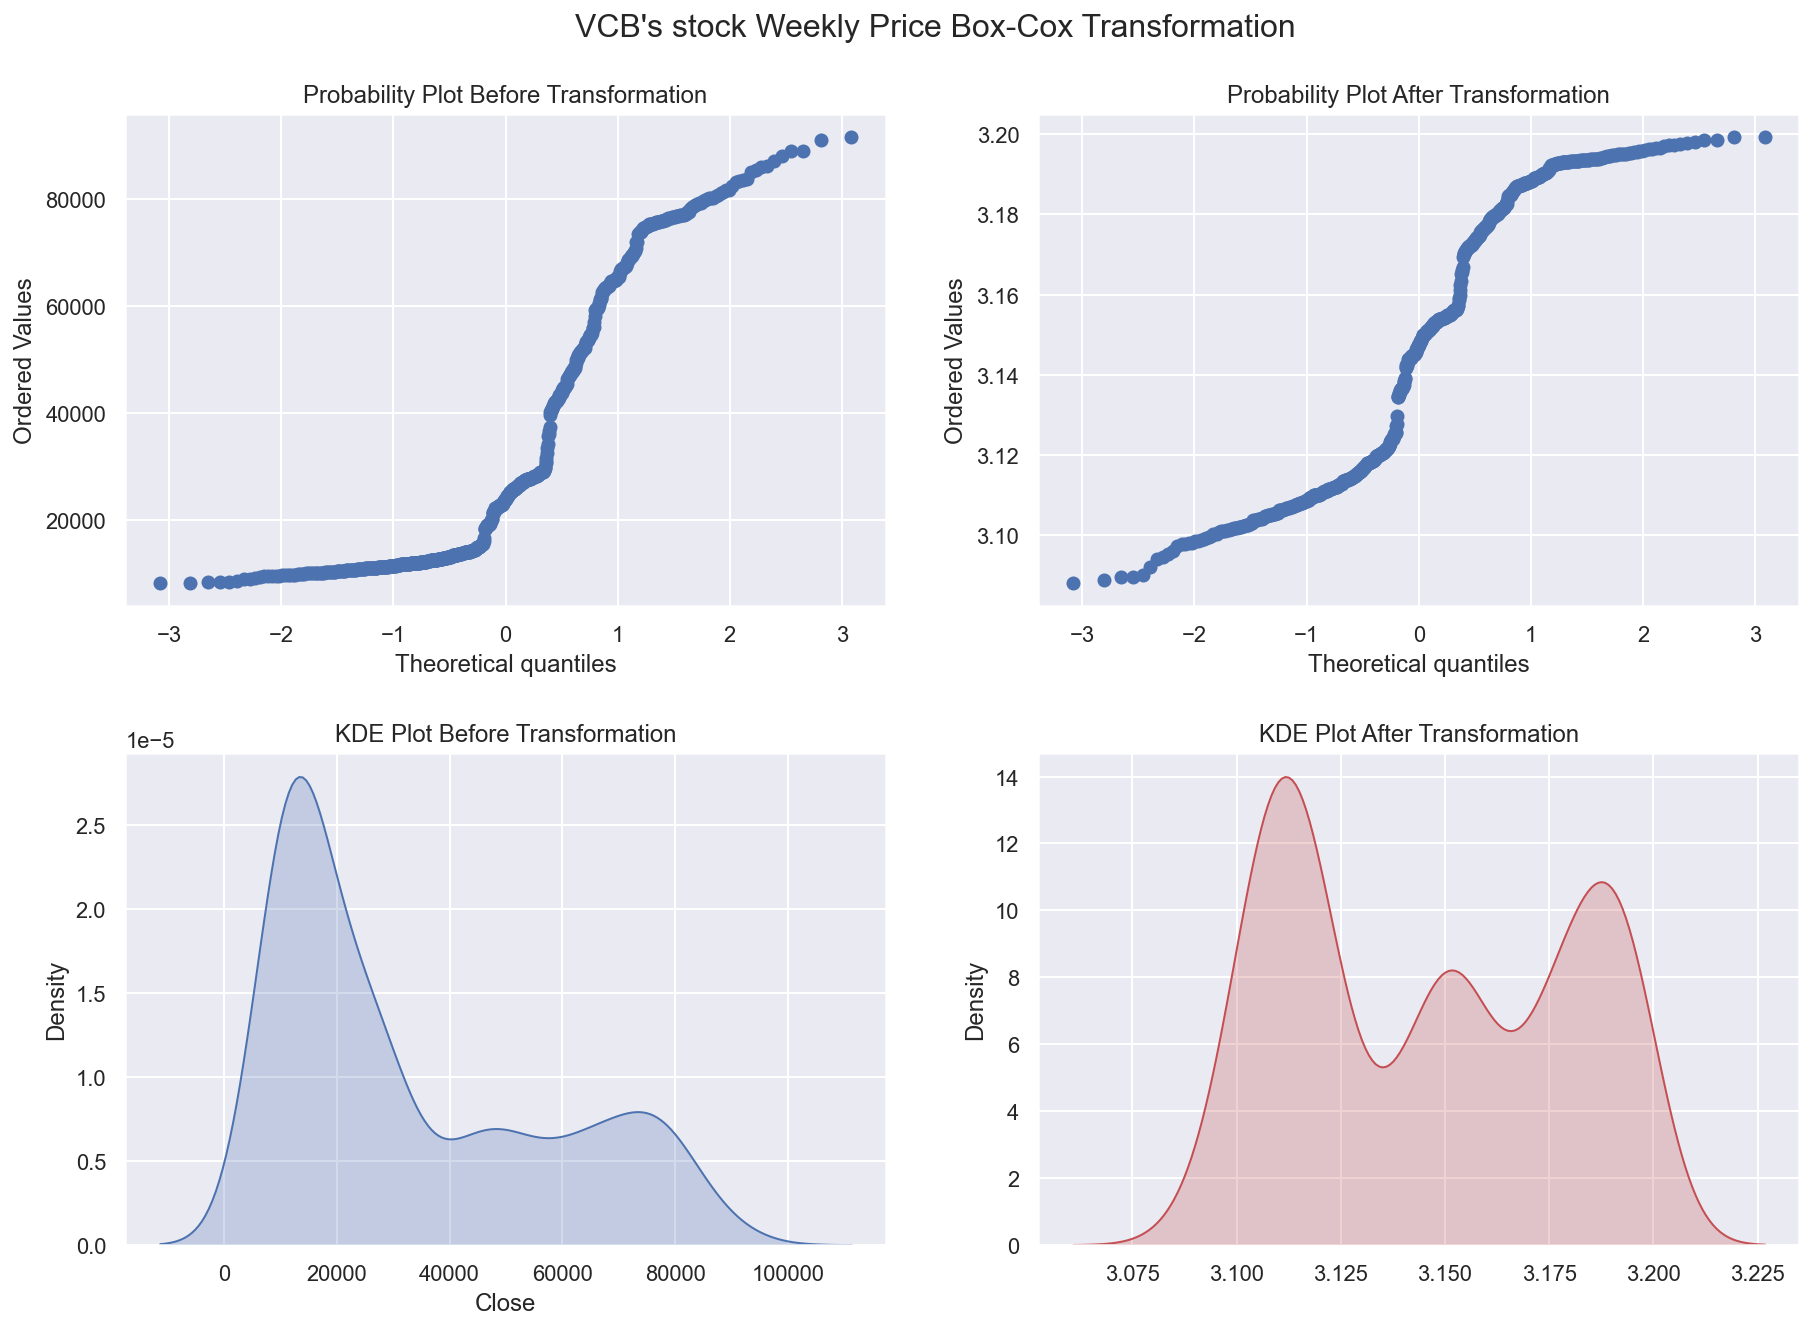

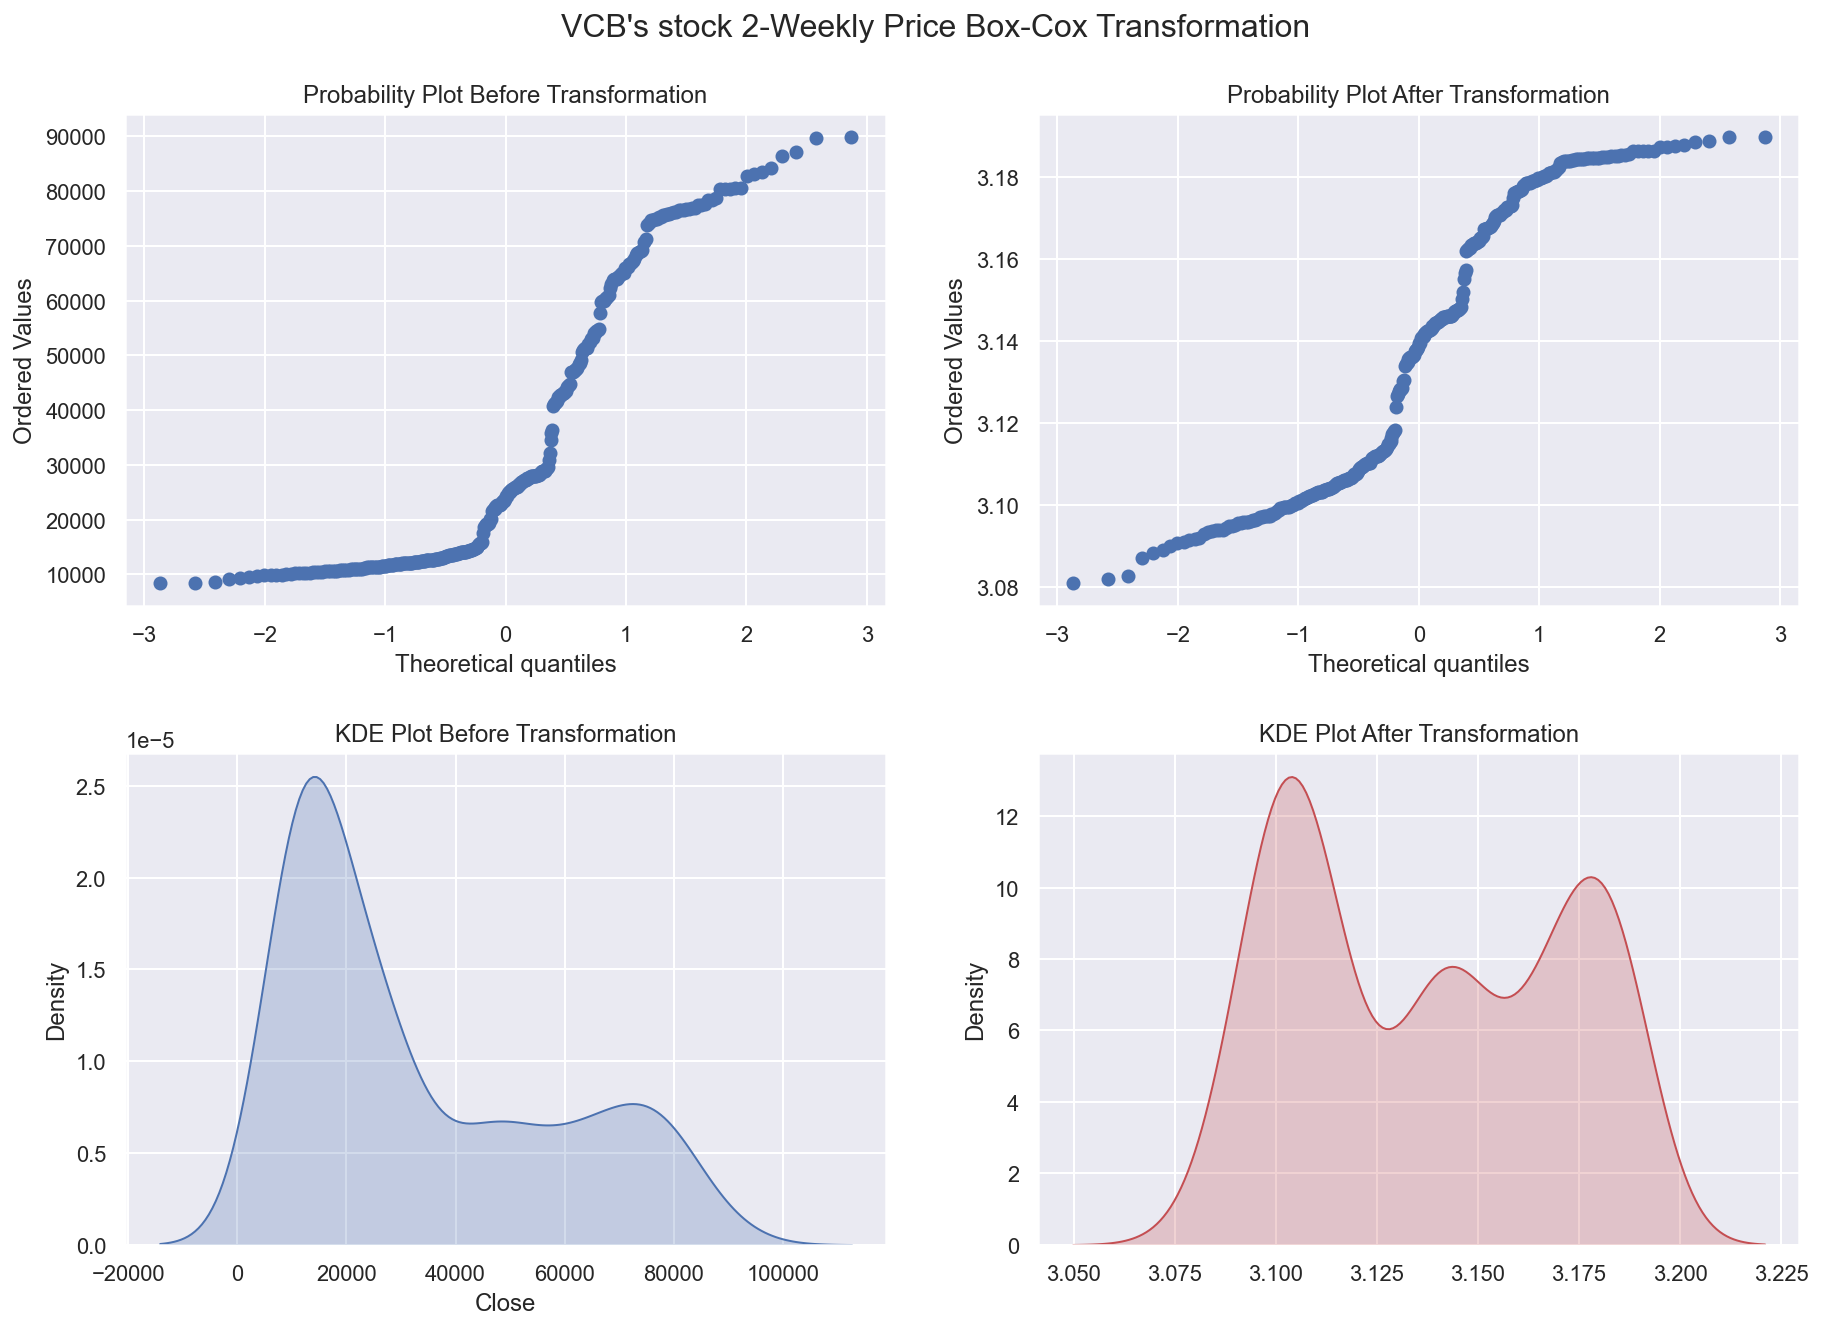

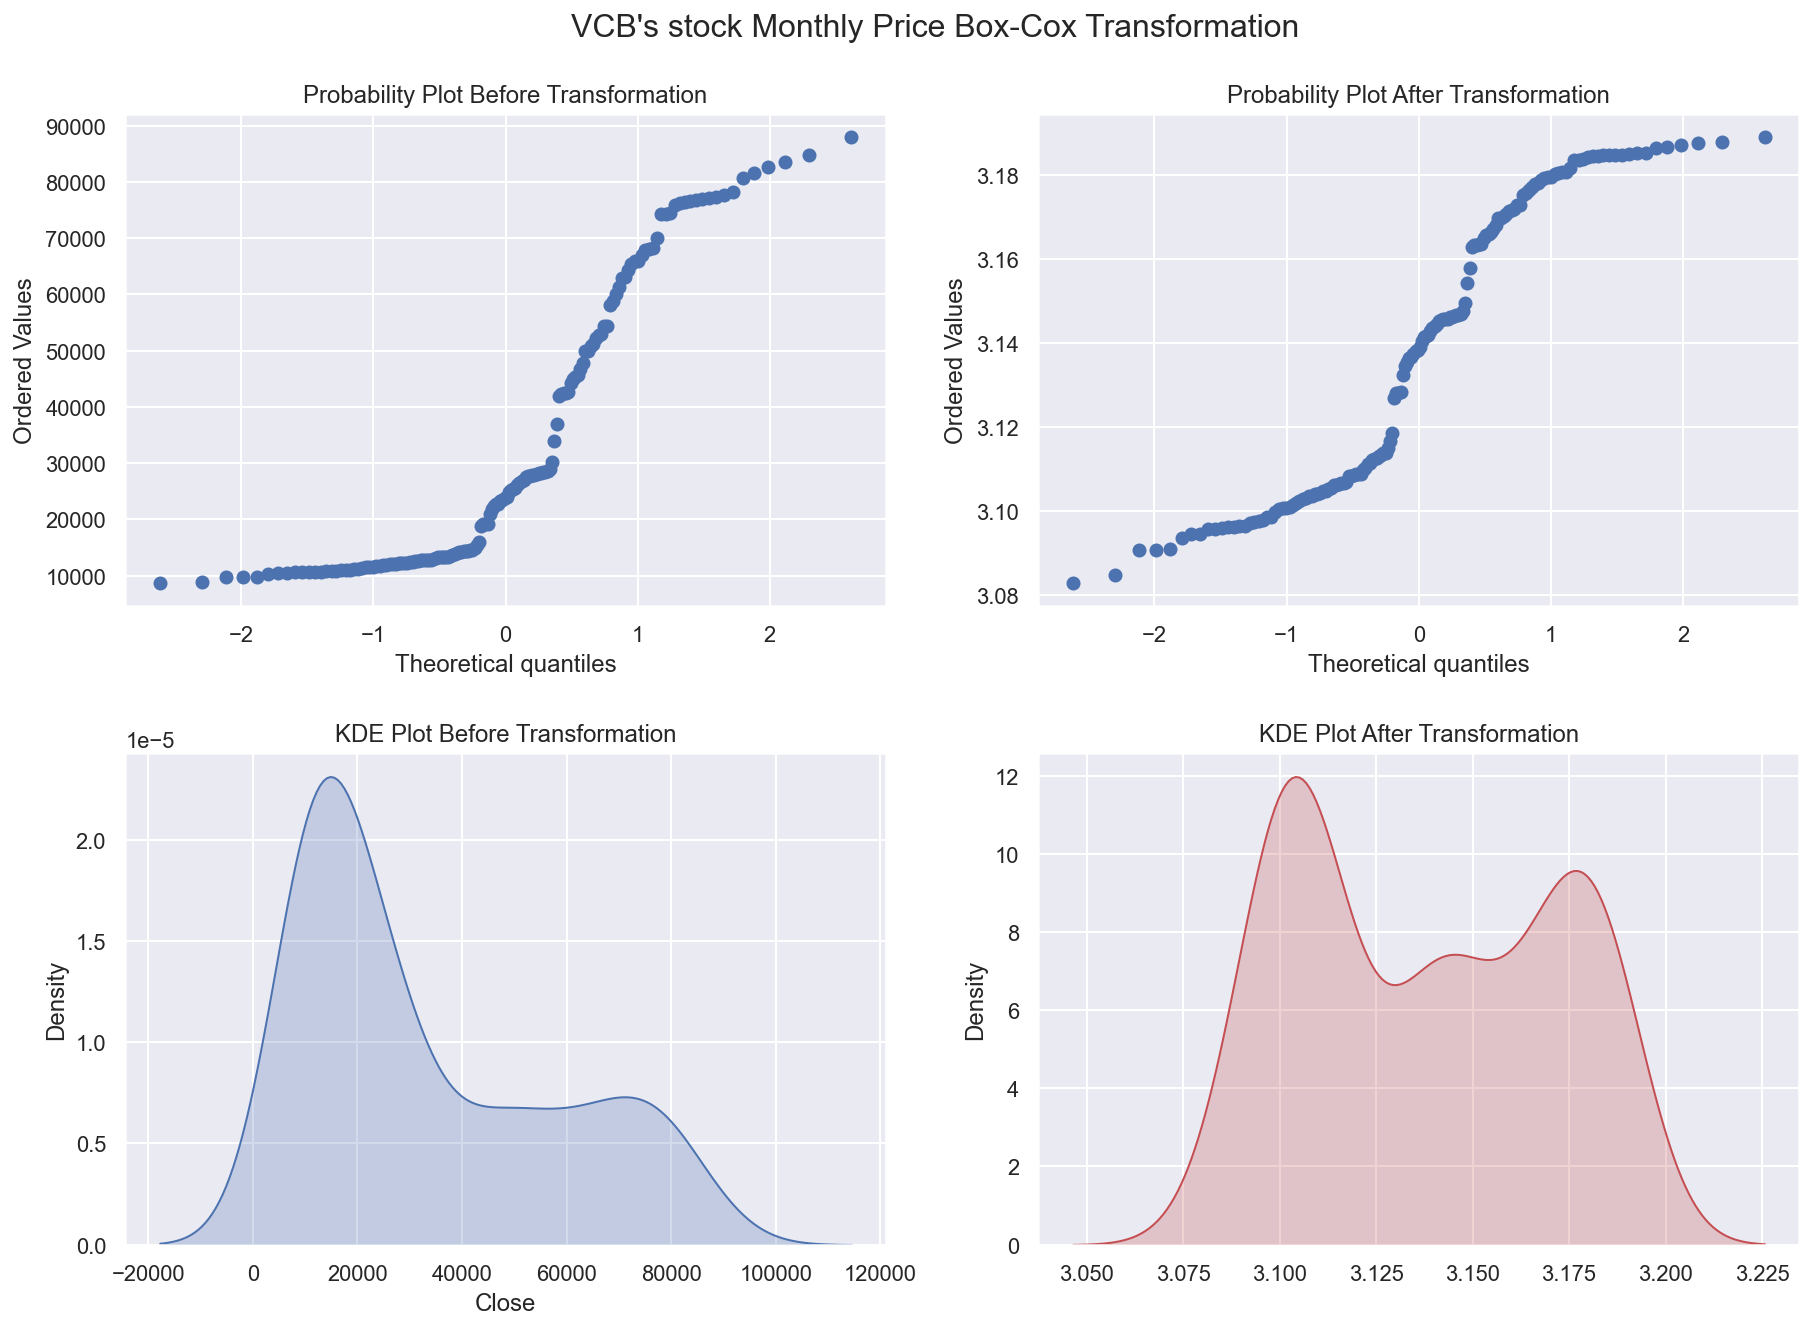

In [10]:
for df in df_list:
    run_box_cox(df)

## FIRST-ORDER DIFFERECING ADF TEST 

In [11]:
print('Box-Cox Transformed Price First-order Differencing ADF Test')
for df in df_list:
    if 'Day' in str(df.index.freq):
        freq = 'Daily'
    elif 'Week: weekday=6' in str(df.index.freq):
        freq = 'Weekly'
    elif '2 * Weeks: weekday=6' in str(df.index.freq):
        freq = '2-Weekly'
    elif 'MonthEnd' in str(df.index.freq):
        freq = 'Monthly'
        
    df['price_box_diff_1'] = df['price_box'] - df['price_box'].shift(1)
    df  =   df.dropna()
    print('{} : p={}'.format(freq, adfuller(df.price_box_diff_1[1:])[1]))

Box-Cox Transformed Price First-order Differencing ADF Test
Daily : p=3.2344767562927607e-29
Weekly : p=0.0
2-Weekly : p=3.867279550556682e-26
Monthly : p=8.253249424784457e-09


## THE INVERSE BOX COX TRANSFORMATION

In [12]:
def inverse_box_cox(time_series, lmbda):
    if lmbda == 0:
        return(np.exp(time_series))
    else:
        return(np.exp(np.log(lmbda*time_series+1)/lmbda))

## AUTOCORRELATIONS (ADF) AND PARTIAL AUTOCORRELATIONS (PADF) 

In [13]:
def run_acf_pacf(time_series, title, lags=40):

    sns.set(style='darkgrid')
    fig_acf_pacf = plt.figure(figsize=(21,7))
    
    first_valid_date = time_series.first_valid_index()
    time_series = time_series.loc[first_valid_date:]

    # Biểu đồ ACF
    ax_acf = plt.subplot2grid((5, 10), (0, 0), rowspan=3, colspan=5)
    plot_acf(time_series, lags=lags, ax=ax_acf, lw=1)
    plt.title('{}'.format(frequency), fontsize=12)
    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10, rotation=0)
    plt.title('Estimated Autocorreclations (ACF)', fontsize=14)

    # Biểu đồ PACF
    ax_pacf = plt.subplot2grid((5, 10), (0, 5), rowspan=3, colspan=5)
    plot_pacf(time_series, lags=lags, ax=ax_pacf, lw=1)
    plt.title('{}'.format(frequency), fontsize=12)
    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10, rotation=0)
    plt.title('Estimated Partial Autocorreclations (PACF)', fontsize=14)

    plt.subplots_adjust(left=0.1, bottom=0.15, right=1, top=0.90, wspace=0.7, hspace=0)
    plt.suptitle(title, fontsize=20)
    
    plt.savefig('images {} First-order Differencing'.format(frequency))
    plt.show()

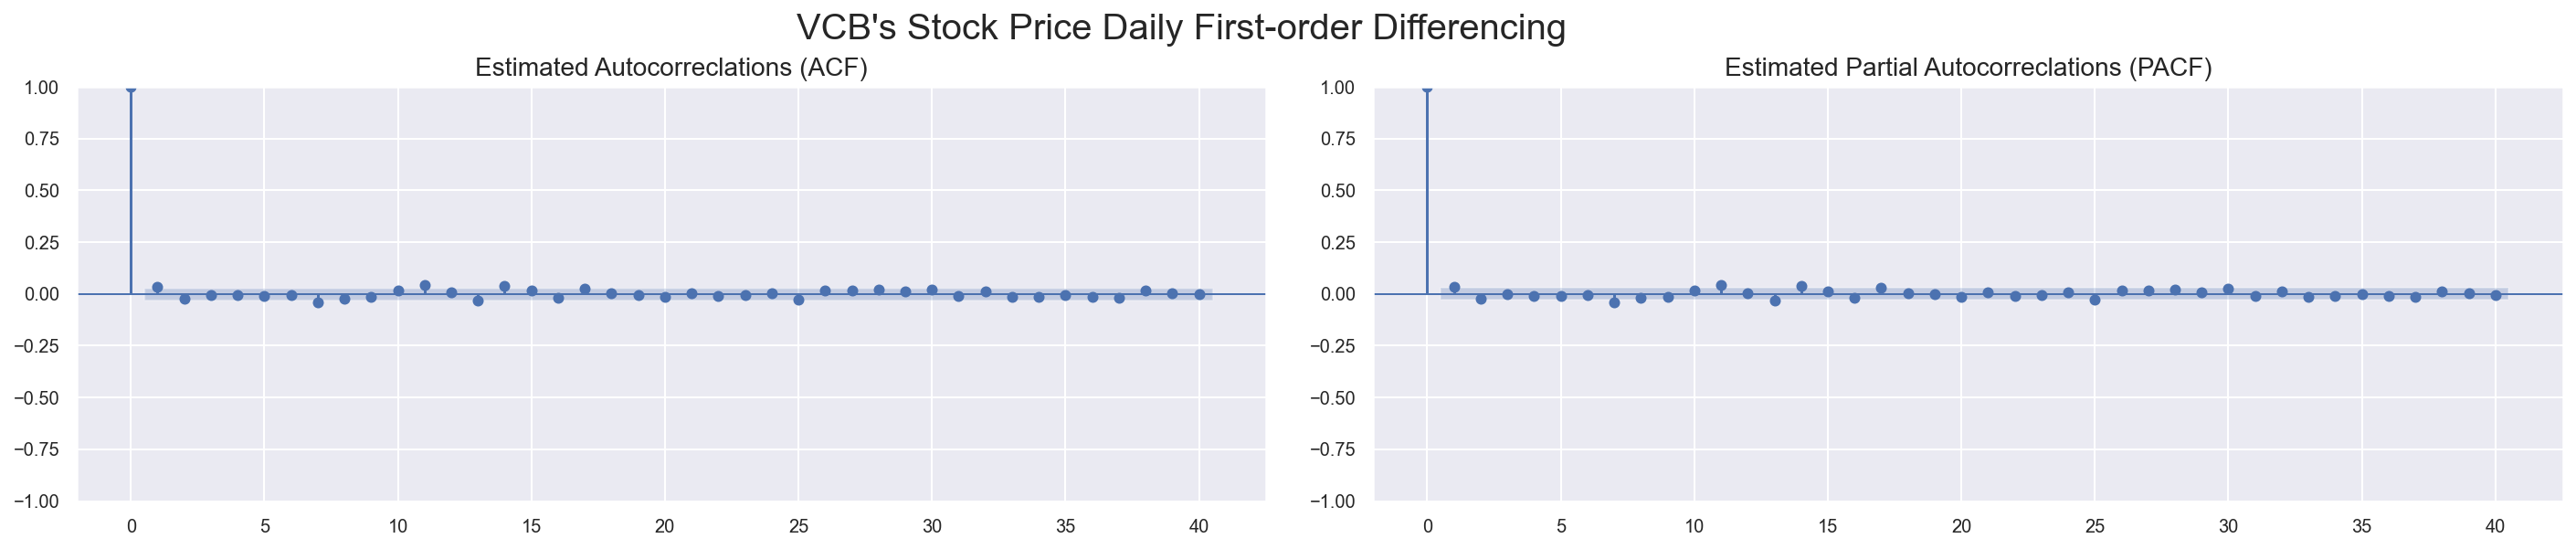

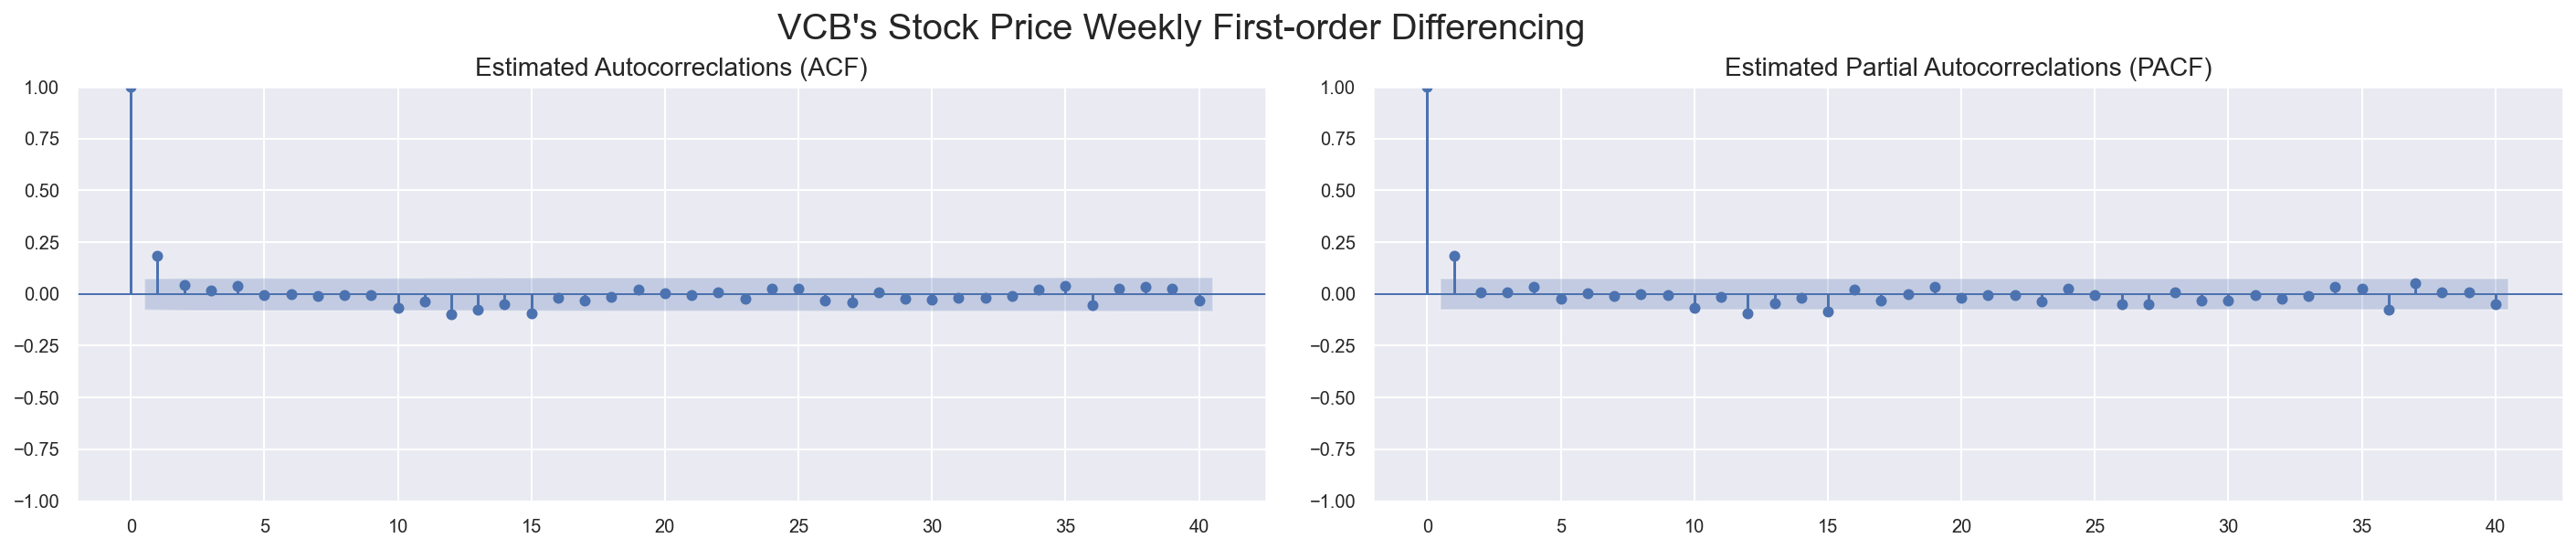

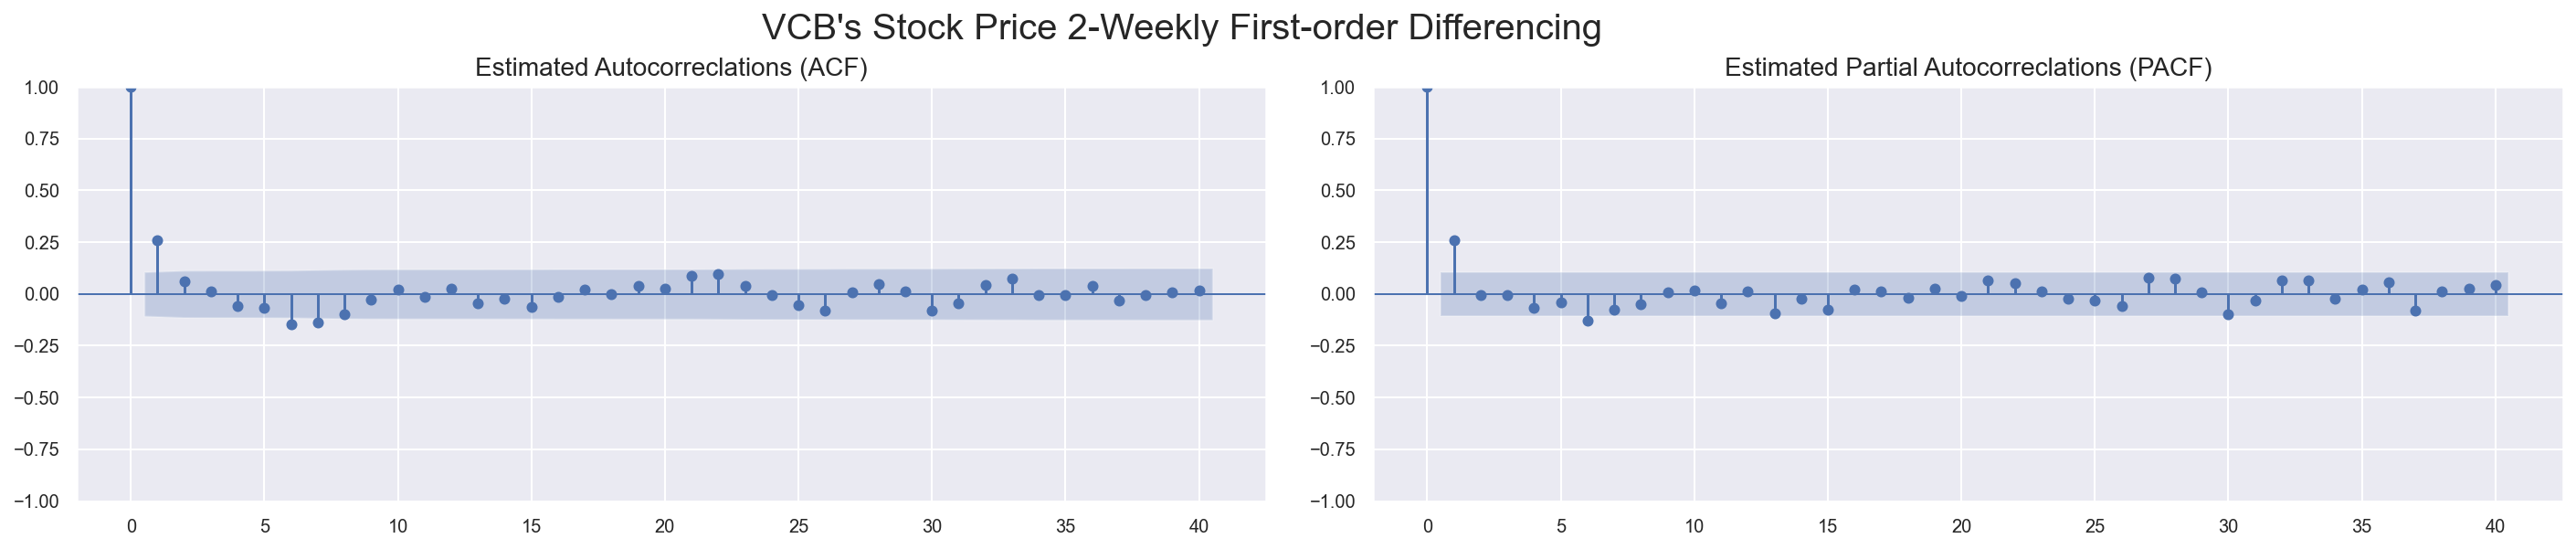

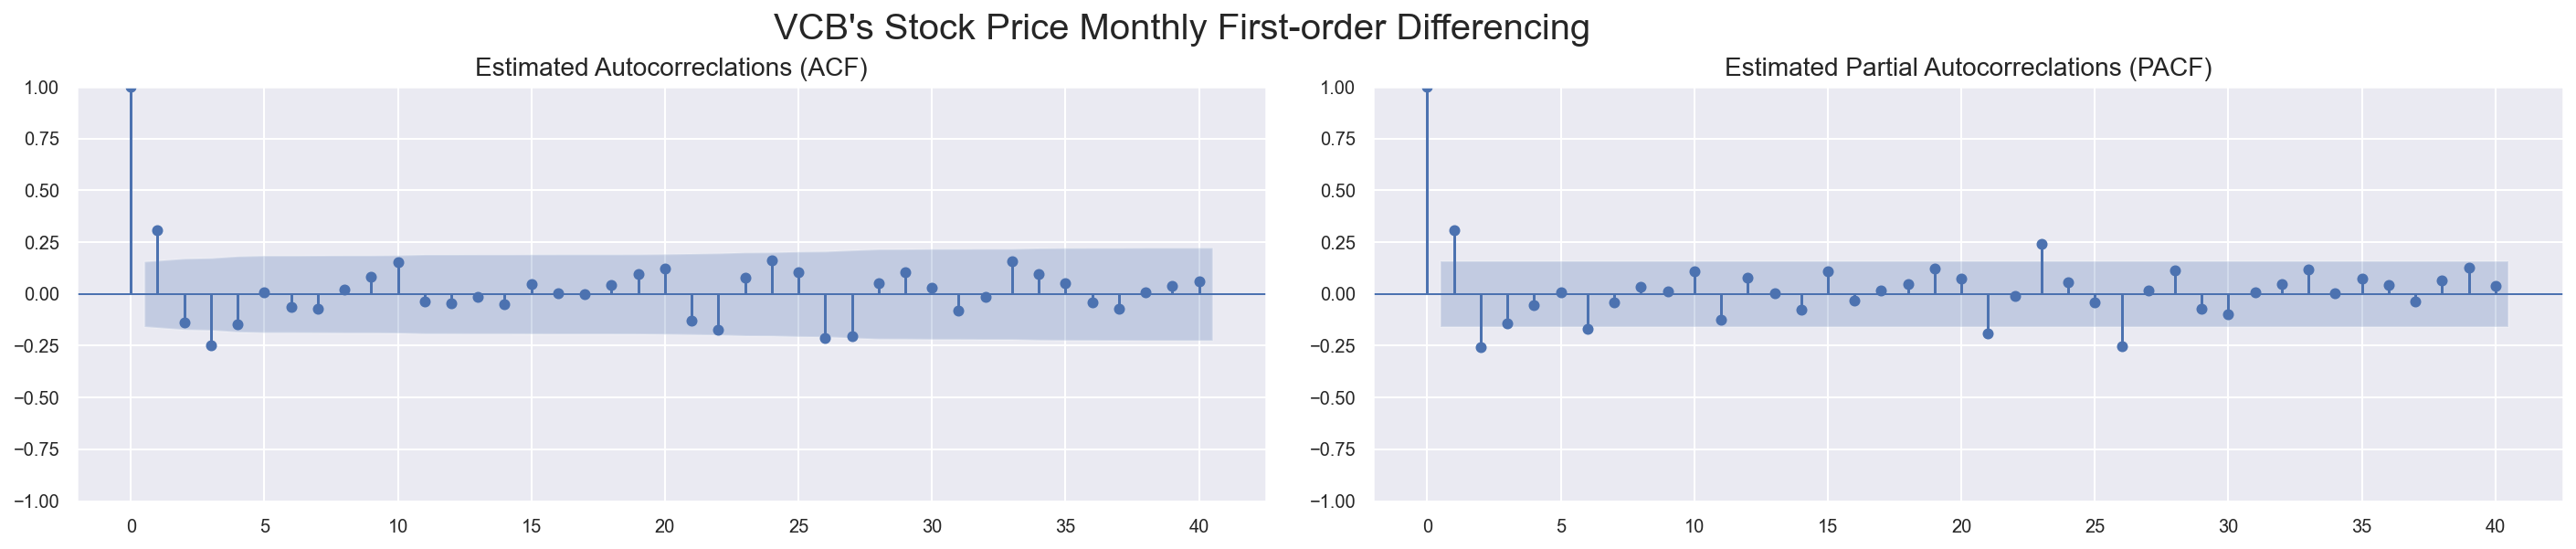

In [14]:
for df in df_list:
    if 'Day' in str(df.index.freq):
        frequency = 'Daily'
    elif 'Week: weekday=6' in str(df.index.freq):
        frequency = 'Weekly'
    elif '2 * Weeks: weekday=6' in str(df.index.freq):
        frequency = '2-Weekly'
    elif 'MonthEnd' in str(df.index.freq):
        frequency = 'Monthly'
        
    run_acf_pacf(df['price_box_diff_1'],"VCB's Stock Price {} First-order Differencing".format(frequency) ,lags=40)

## SELECT PARAMS

In [15]:
def select_best_params(pd_dataframe):
    frequency = []
    if 'Day' in str(df.index.freq):
        frequency = 'Daily'
    elif 'Week: weekday=6' in str(df.index.freq):
        frequency = 'Weekly'
    elif '2 * Weeks: weekday=6' in str(df.index.freq):
        frequency = '2-weekly'
    elif 'MonthEnd' in str(df.index.freq):
        frequency = 'Monthly'
    print('Litecoin/USD {} 1st Order Differencing Best (p, d, q):'.format(frequency))
    
    # Create params step
    ps = range(0, 10)
    ds= range(1, 2)
    qs = range(0, 3)
    parameters = product(ps, ds, qs)
    parameters_list = list(parameters)

    # select params
    best_params = []
    aic_results = []
    bic_results = []
    hqic_results = []
    best_aic = float("inf")
    best_bic = float("inf")
    best_hqic = float("inf")
    warnings.filterwarnings('ignore')
    for param in parameters_list:
        try:
            model = SARIMAX(pd_dataframe['price_box'], order=(param[0], param[1], param[2])).fit(disp=-1)
        except ValueError:
            continue    
           
        aic_results.append([param, model.aic])
        bic_results.append([param, model.bic])
        hqic_results.append([param, model.hqic])
        
    aic_df = pd.DataFrame(aic_results)
    aic_df.columns = ['params', 'aic']   
    best_params.append(aic_df.params[aic_df.aic.idxmin()])
    print('AIC best param: {}'.format(aic_df.params[aic_df.aic.idxmin()]))
    
    bic_df = pd.DataFrame(bic_results)
    bic_df.columns = ['params', 'bic']
    best_params.append(bic_df.params[bic_df.bic.idxmin()])
    print('BIC best param: {}'.format(bic_df.params[bic_df.bic.idxmin()]))
    
    hqic_df = pd.DataFrame(hqic_results)
    hqic_df.columns = ['params', 'hqic']
    best_params.append(hqic_df.params[hqic_df.hqic.idxmin()])
    print('HQIC best param: {}'.format(hqic_df.params[hqic_df.hqic.idxmin()]))

    for best_param in best_params:
        if best_params.count(best_param)>=2:
            print('Best Param Selected: {}'.format(best_param))
            return best_param 

# RENDER THE RESULTS 

In [16]:
def render_results(pd_dataframe, params=None, steps=3):
    # lmbda
    lmbda=pd_dataframe.lmbda[0]
    
    # Params
    if not params:
        params = select_best_params(pd_dataframe)
    
    # Dũ liệu
    training_ts = pd_dataframe.loc[:"2019", 'price_box'] 
    testing_ts = pd_dataframe.loc["2019":, 'price_box']
    
    # Train the model
    training_model = SARIMAX(endog=training_ts, order=params)
    training_model_fit = training_model.fit(disp=False)
    
    # Test the model
    testing_model = SARIMAX(endog=testing_ts, order=params)
    testing_model_fit = testing_model.smooth(training_model_fit.params)
    
    # Prediction
    prediction_wrapper = testing_model_fit.get_prediction(start=int(testing_model.nobs * 0.2), 
                                                          end=testing_model.nobs + steps, 
                                                          full_reports=True)    
    prediction_ci = prediction_wrapper.conf_int() 
    prediction = prediction_wrapper.predicted_mean
    
    # Inverse Box-Cox Transformation    
    prediction_inversed = inverse_box_cox(prediction, lmbda)  
    prediction_ci_inversed = inverse_box_cox(prediction_ci, lmbda)  
    
    if 'Day' in str(pd_dataframe.index.freq):
        frequency = 'Daily'
        future_dates = pd.date_range(pd_dataframe.index[-1] + timedelta(days=1), periods=steps, freq='D')       
    elif 'Week: weekday=6' in str(pd_dataframe.index.freq):
        frequency = 'Weekly'
        future_dates = pd.date_range(pd_dataframe.index[-1] + timedelta(weeks=1), periods=steps, freq='W')       
    elif '2 * Weeks: weekday=6' in str(pd_dataframe.index.freq):
        frequency = '2-Weekly'
        future_dates = pd.date_range(pd_dataframe.index[-1] + timedelta(weeks=2), periods=steps, freq='2W')        
    elif 'MonthEnd' in str(pd_dataframe.index.freq):
        frequency = 'Monthly'
        future_dates = pd.date_range(pd_dataframe.index[-1] + timedelta(days=30), periods=steps, freq='1M')       
    
    future = pd.DataFrame(index=future_dates, columns=pd_dataframe.columns)
    
    pd_dataframe = pd.concat([pd_dataframe, future])
    pd_dataframe['forecast price_box'] = prediction
    pd_dataframe['lower price_box'] = prediction_ci.iloc[:, 0]
    pd_dataframe['upper price_box'] = prediction_ci.iloc[:, 1]
    pd_dataframe['forecast'] = prediction_inversed.round(2)
    pd_dataframe['lower forecast'] = inverse_box_cox(pd_dataframe['lower price_box'], lmbda)
    pd_dataframe['upper forecast'] = inverse_box_cox(pd_dataframe['upper price_box'], lmbda)
    make_log_price_chart(pd_dataframe, frequency=frequency)

Litecoin/USD Daily 1st Order Differencing Best (p, d, q):
AIC best param: (2, 1, 0)
BIC best param: (0, 1, 0)
HQIC best param: (0, 1, 1)


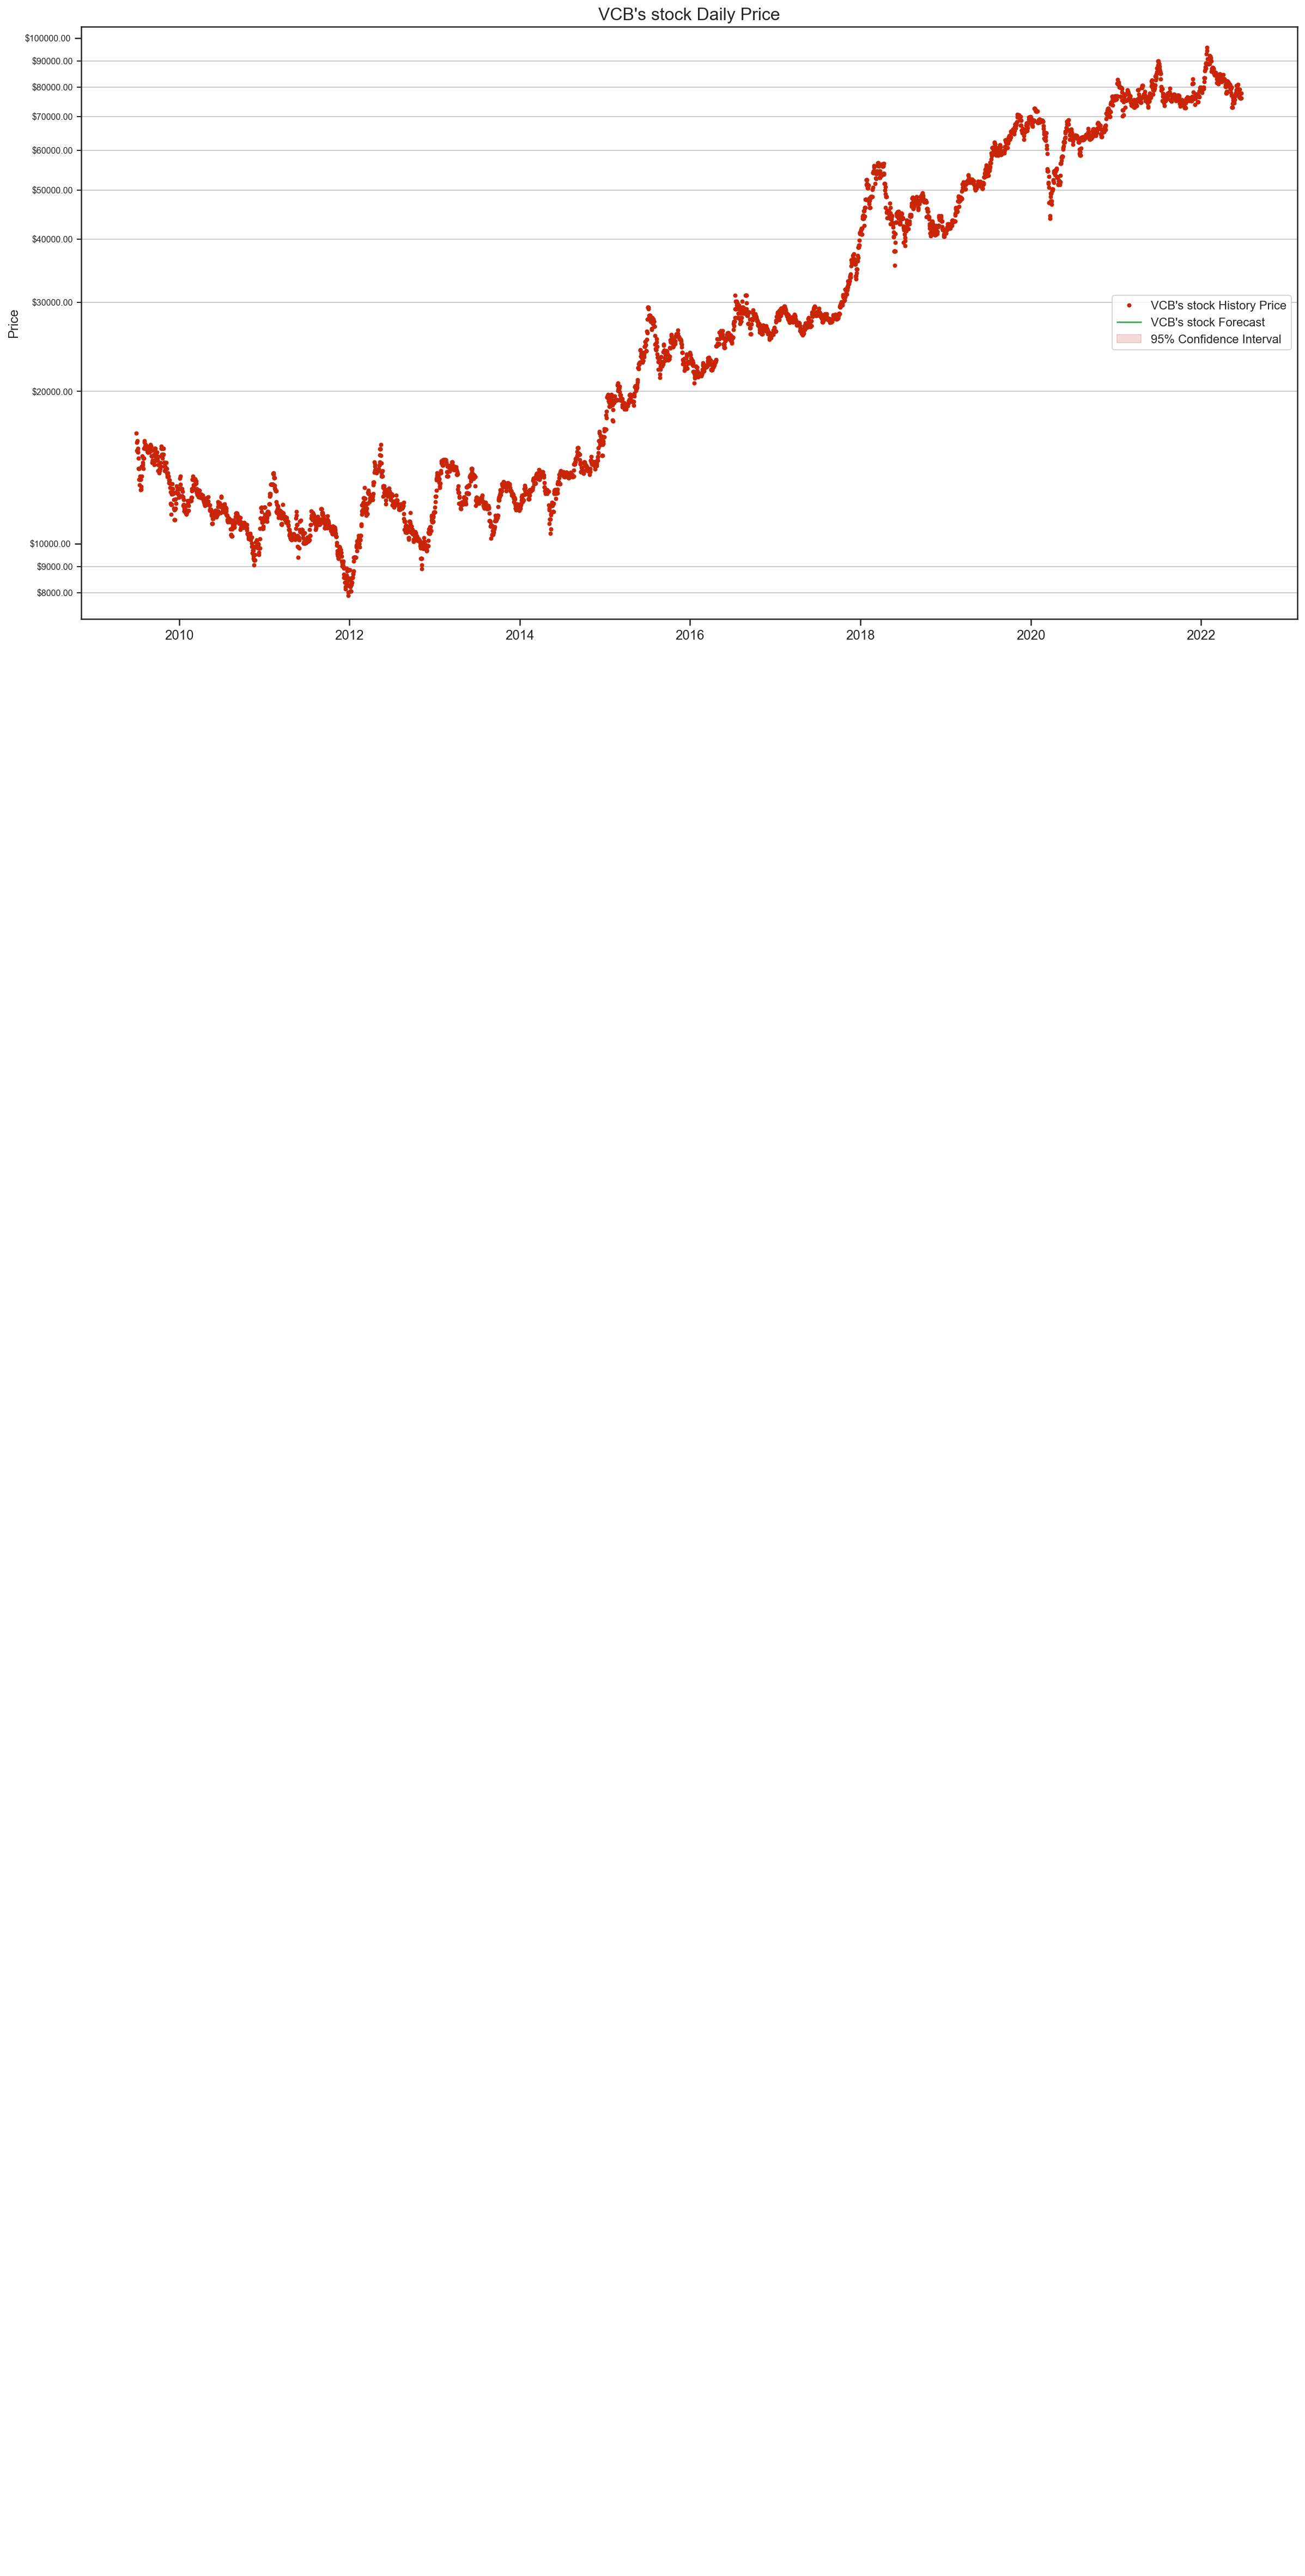

Litecoin/USD Weekly 1st Order Differencing Best (p, d, q):
AIC best param: (1, 1, 0)
BIC best param: (1, 1, 0)
HQIC best param: (1, 1, 0)
Best Param Selected: (1, 1, 0)


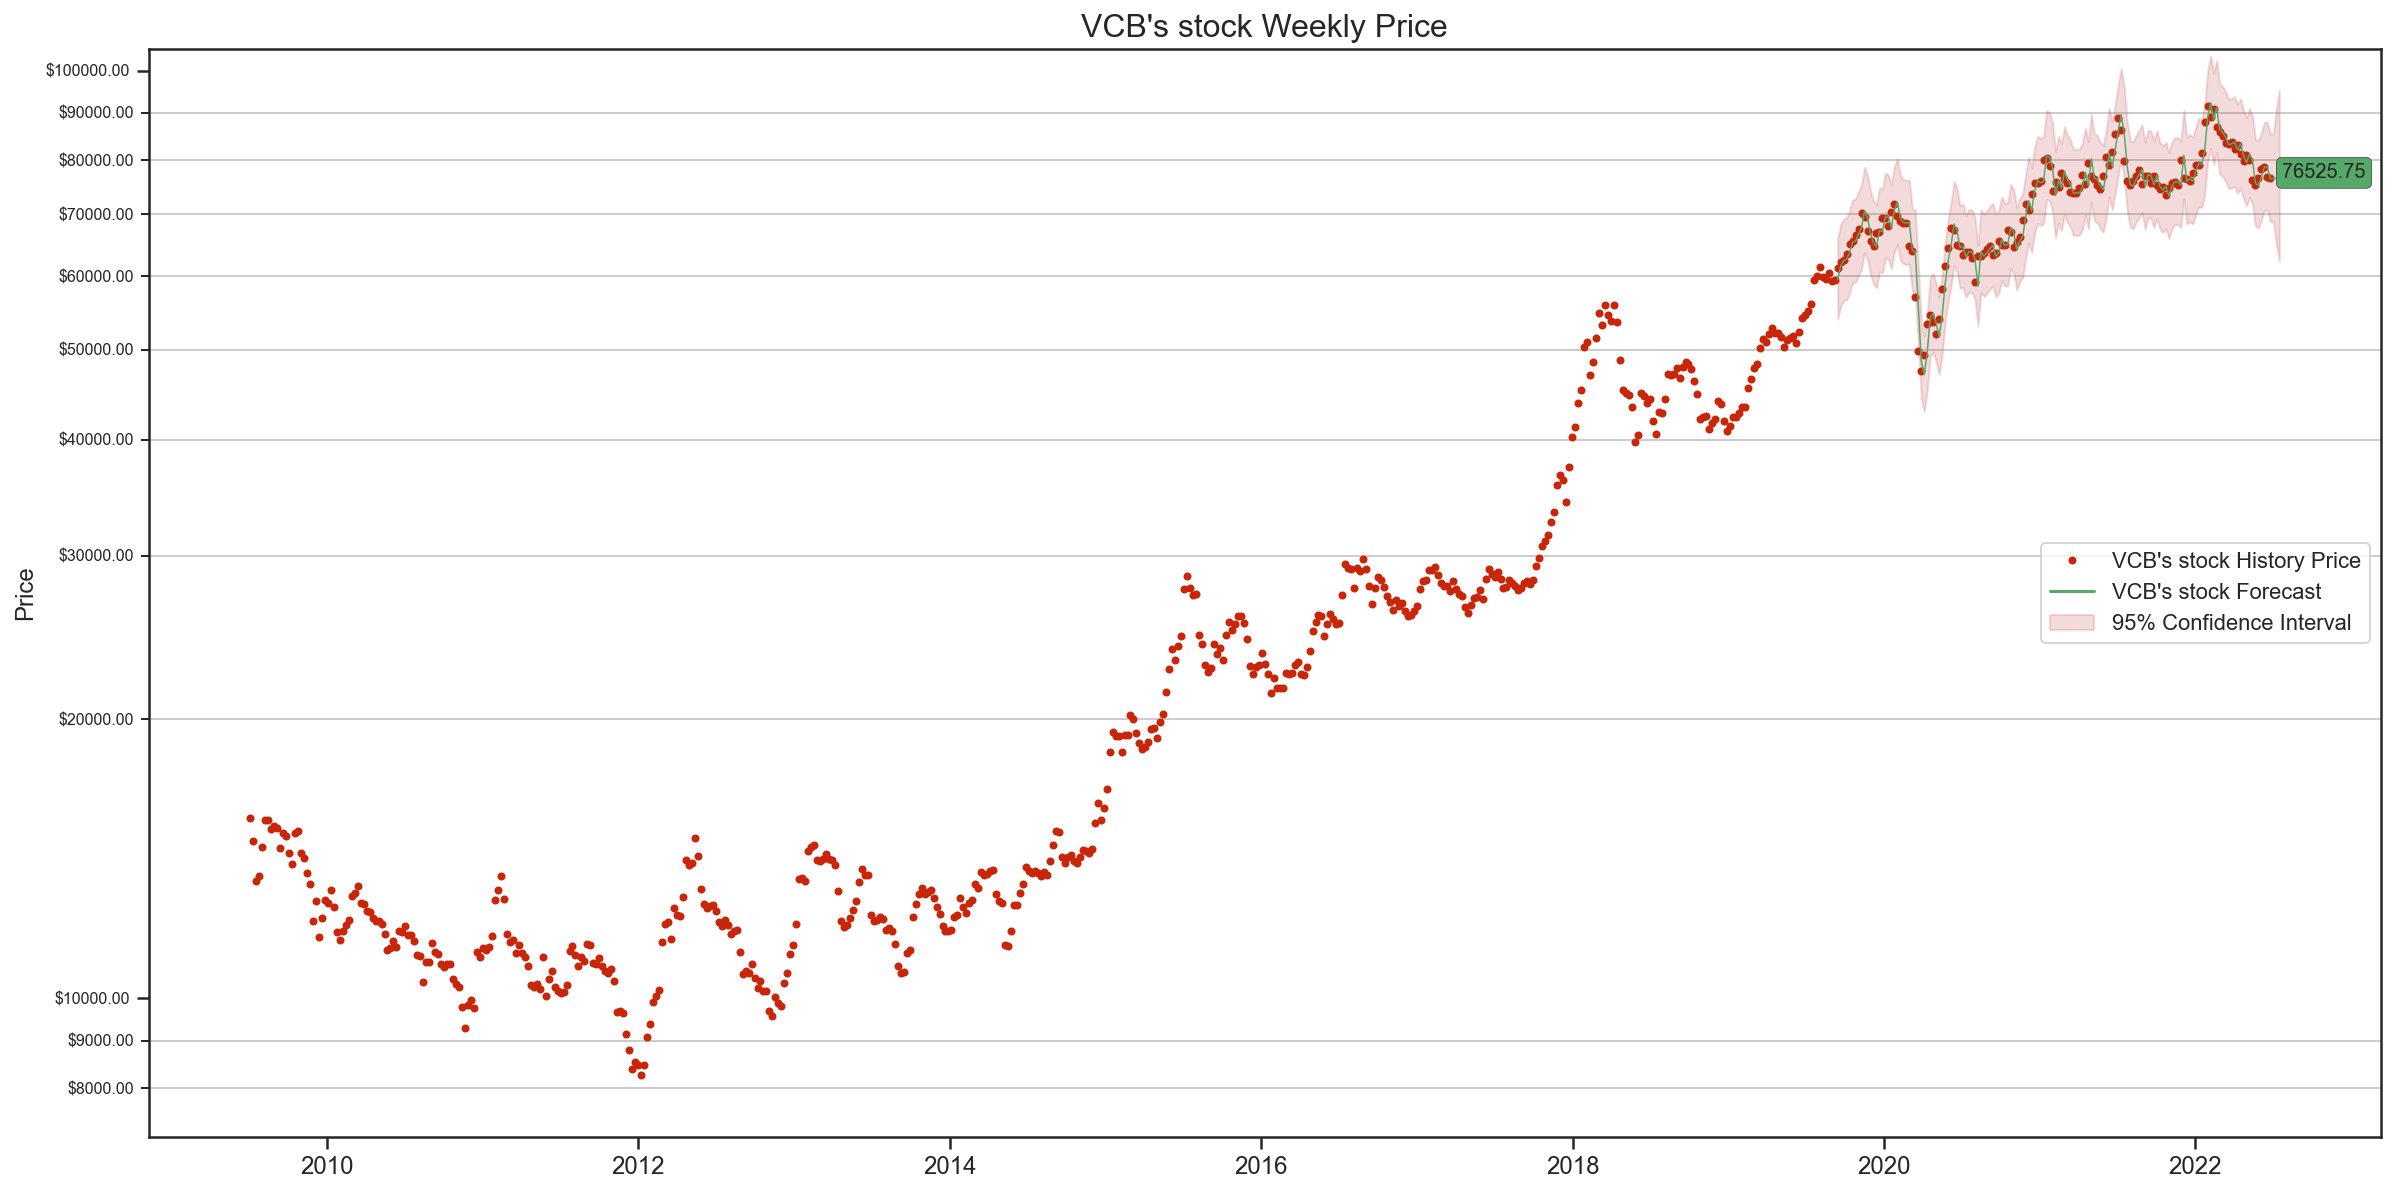

Litecoin/USD 2-weekly 1st Order Differencing Best (p, d, q):
AIC best param: (1, 1, 0)
BIC best param: (1, 1, 0)
HQIC best param: (1, 1, 0)
Best Param Selected: (1, 1, 0)


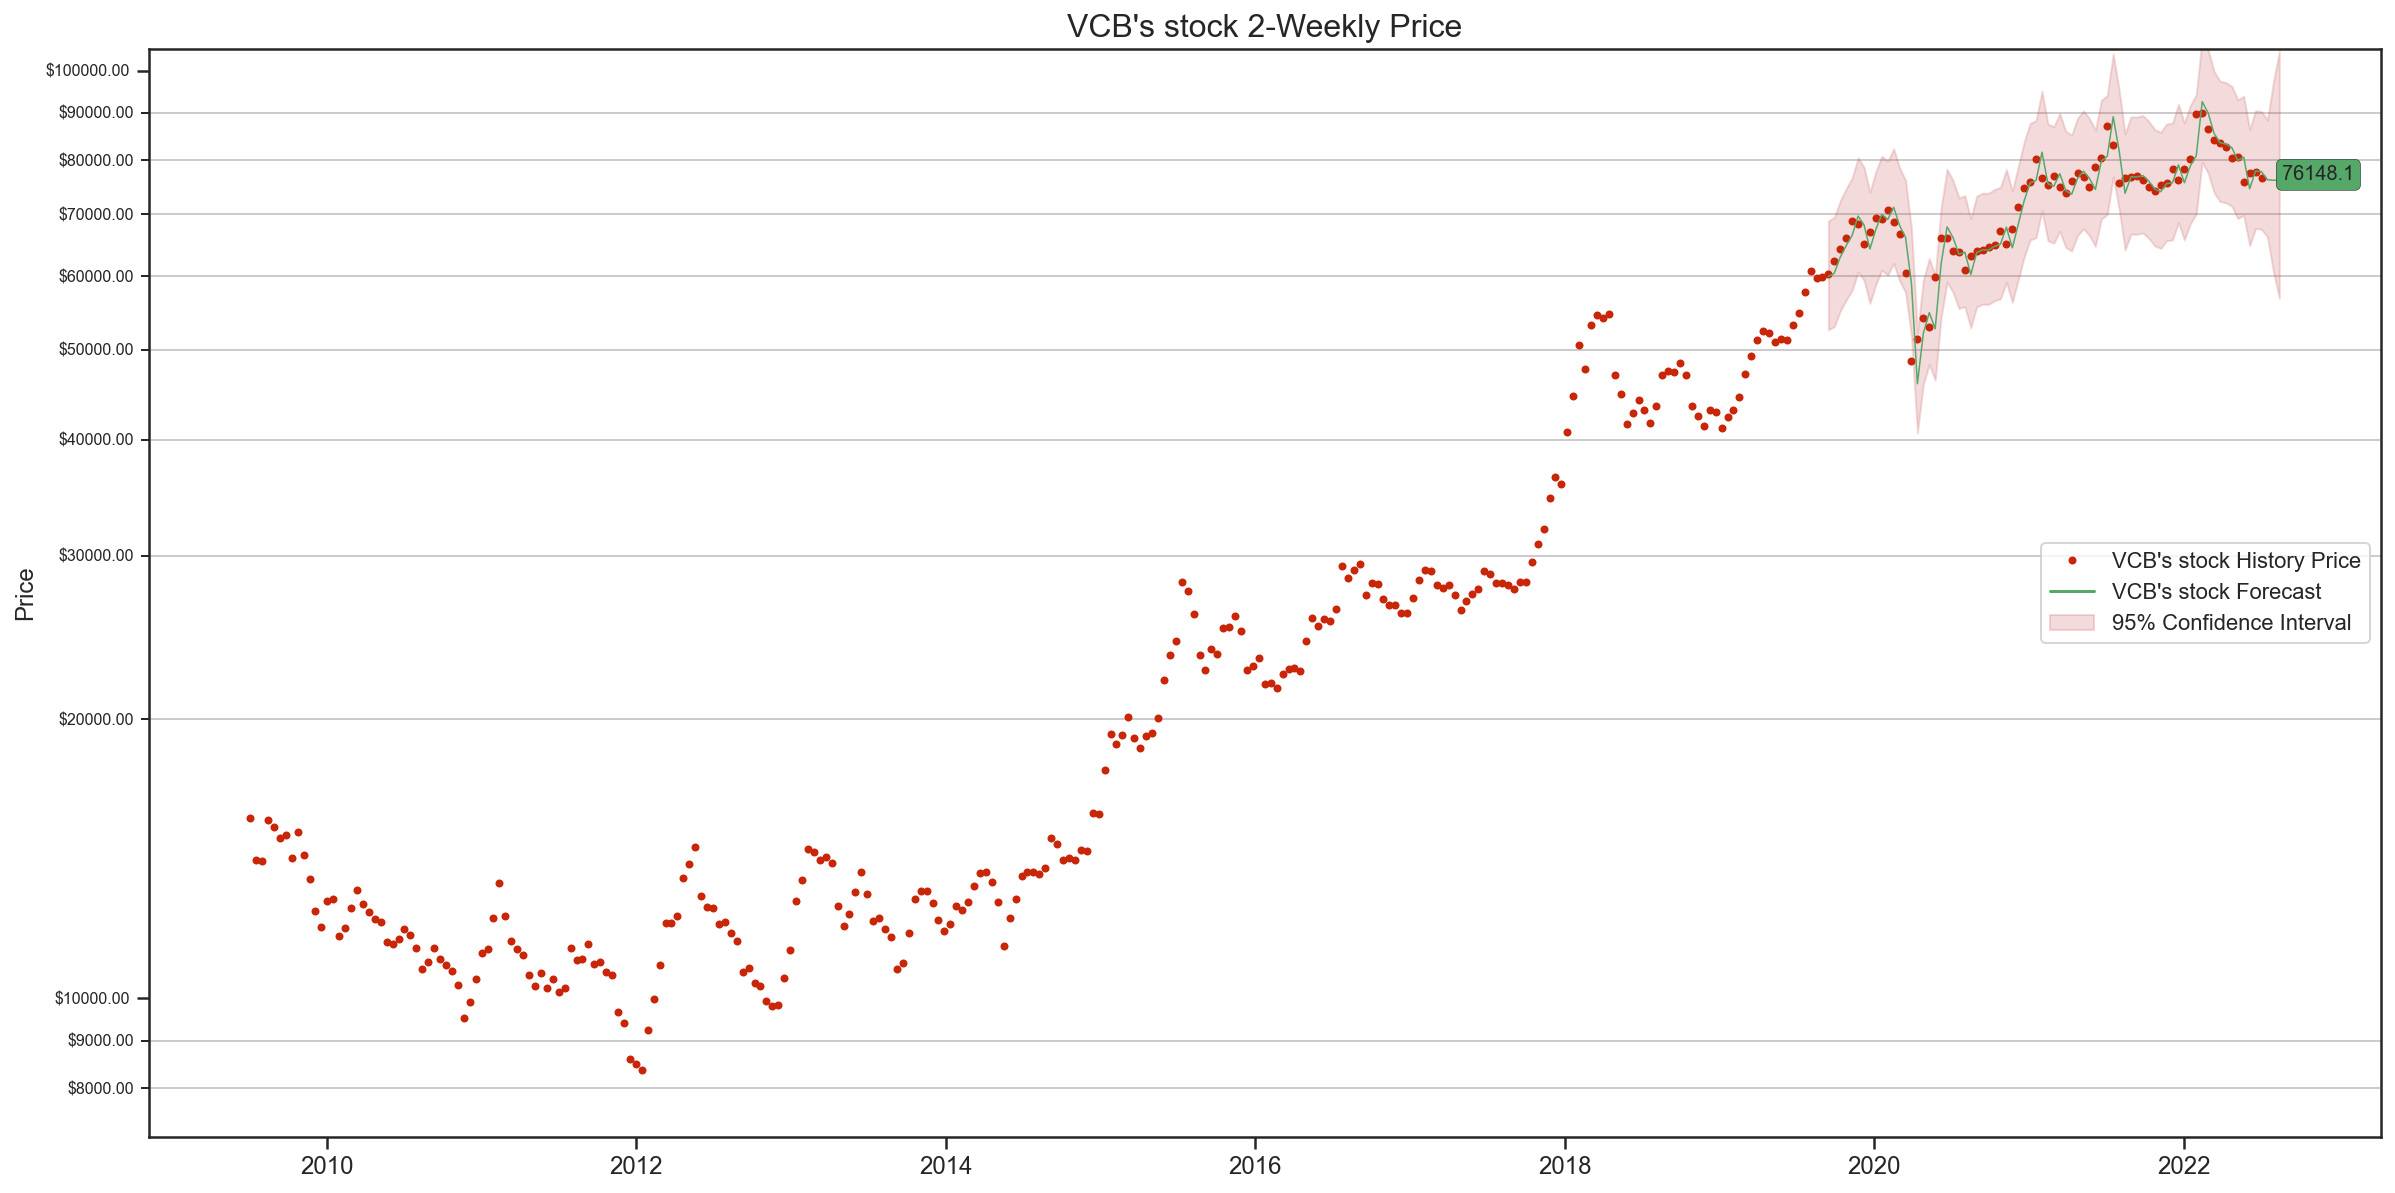

Litecoin/USD Monthly 1st Order Differencing Best (p, d, q):
AIC best param: (2, 1, 1)
BIC best param: (0, 1, 1)
HQIC best param: (2, 1, 0)


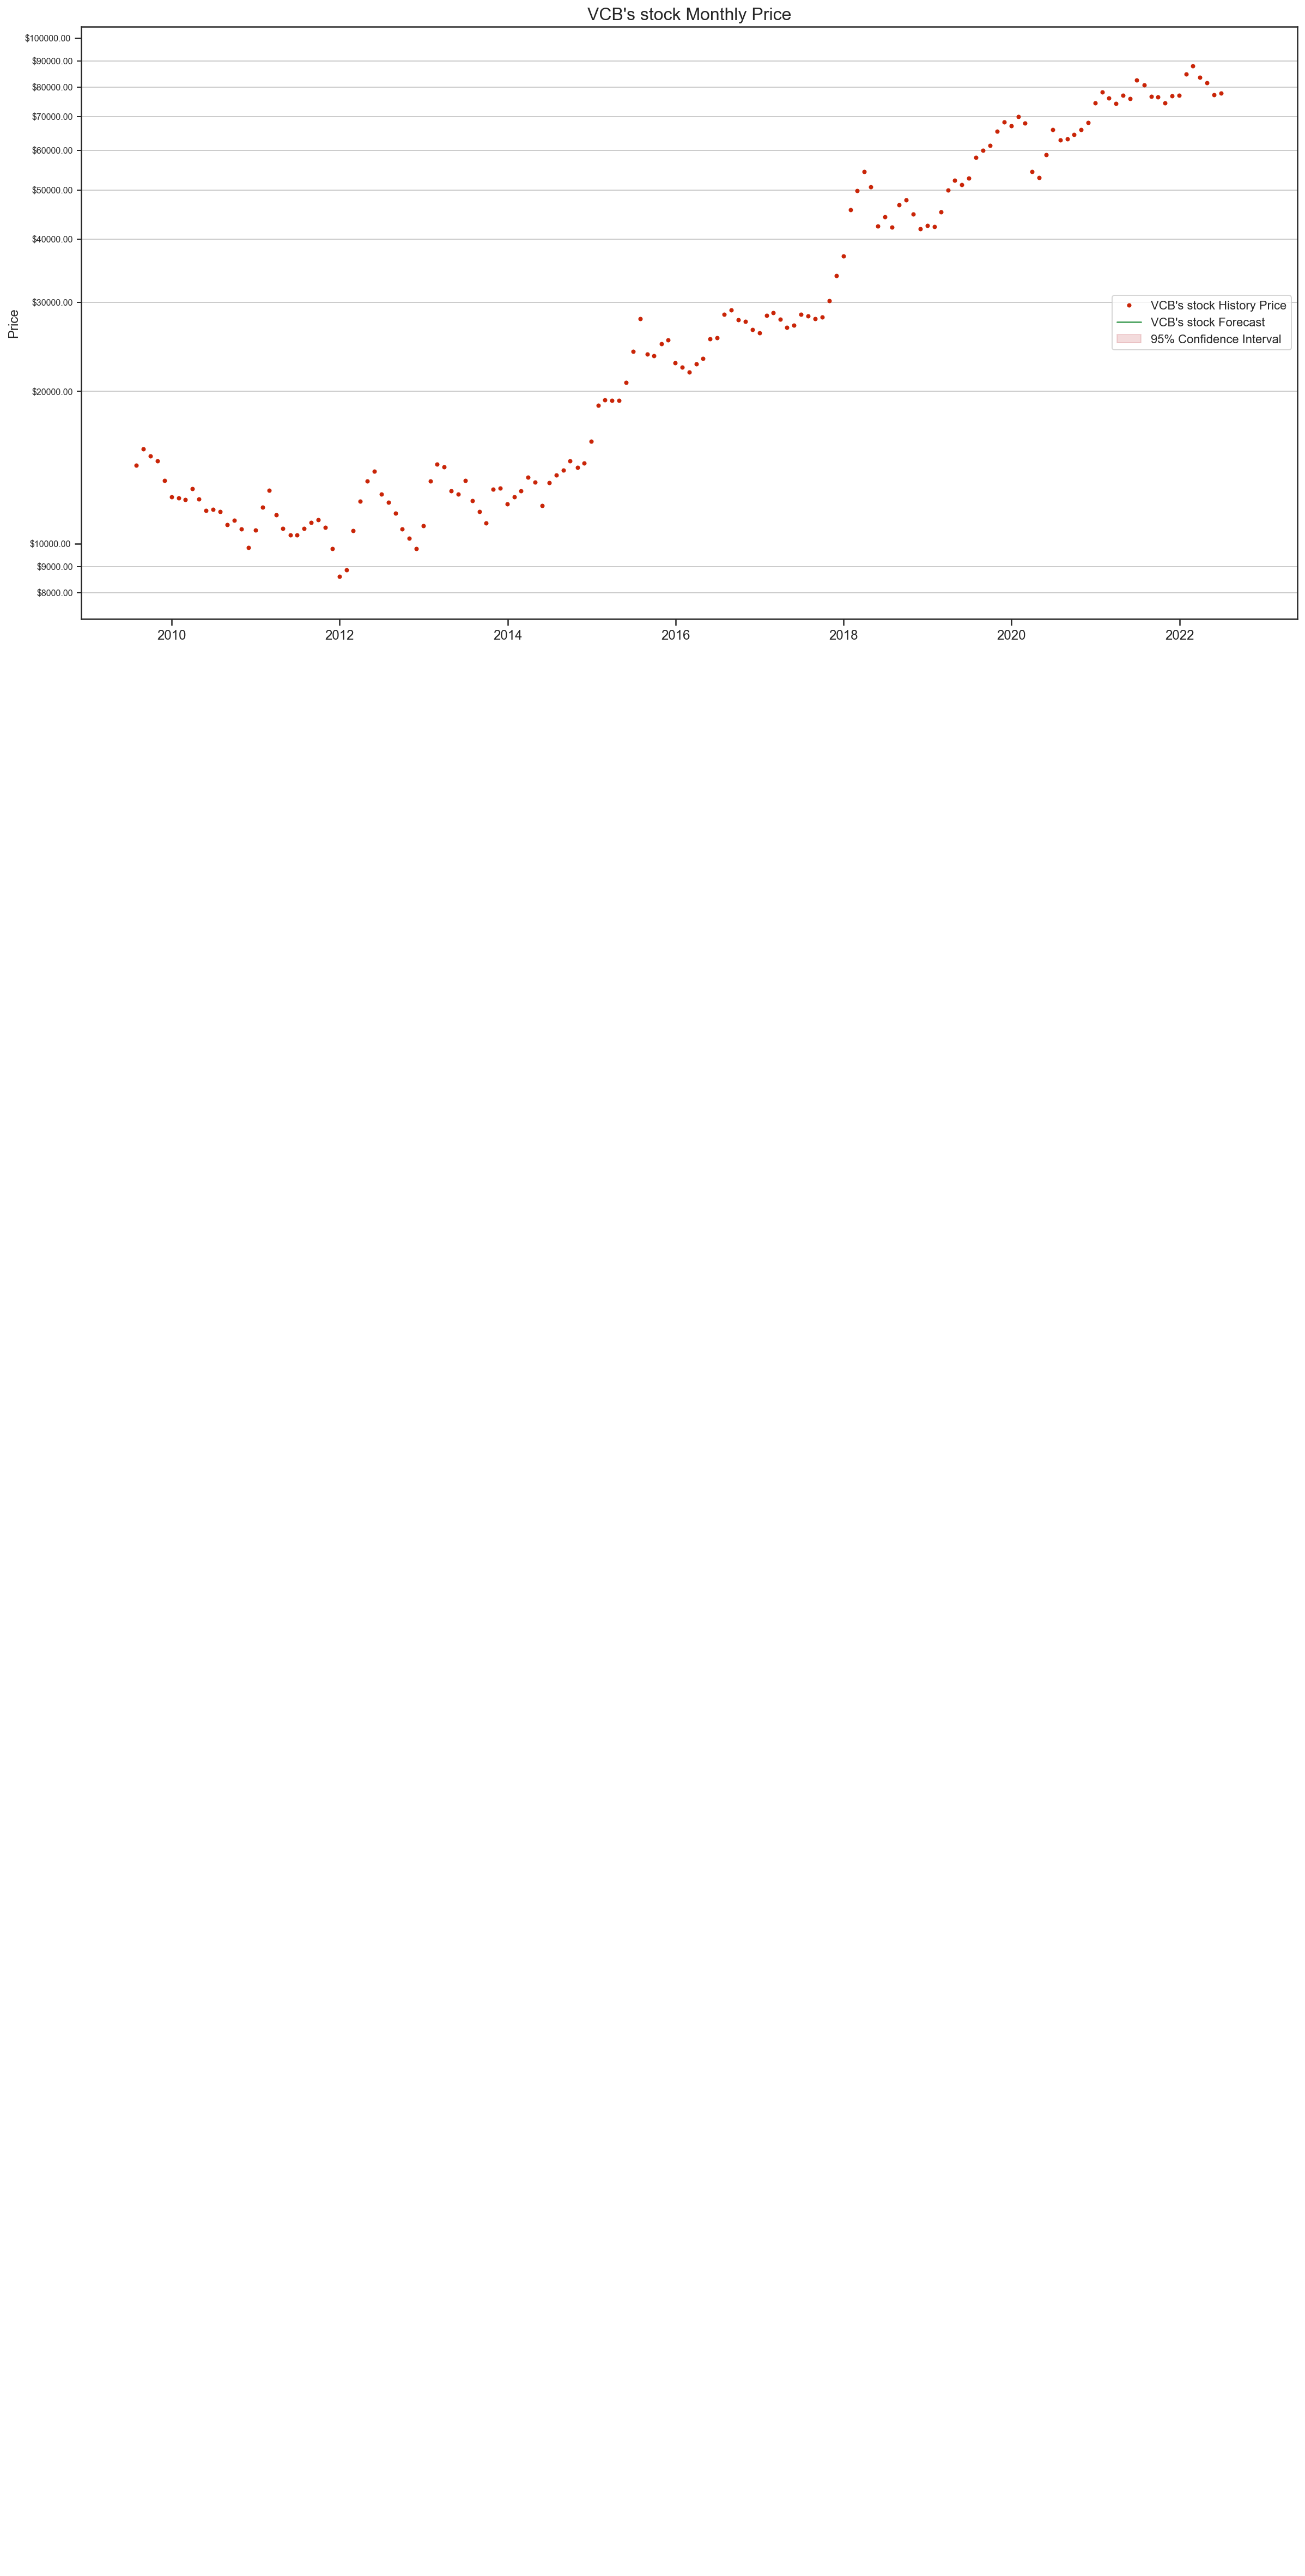

In [17]:
for df in df_list:
    render_results(df)

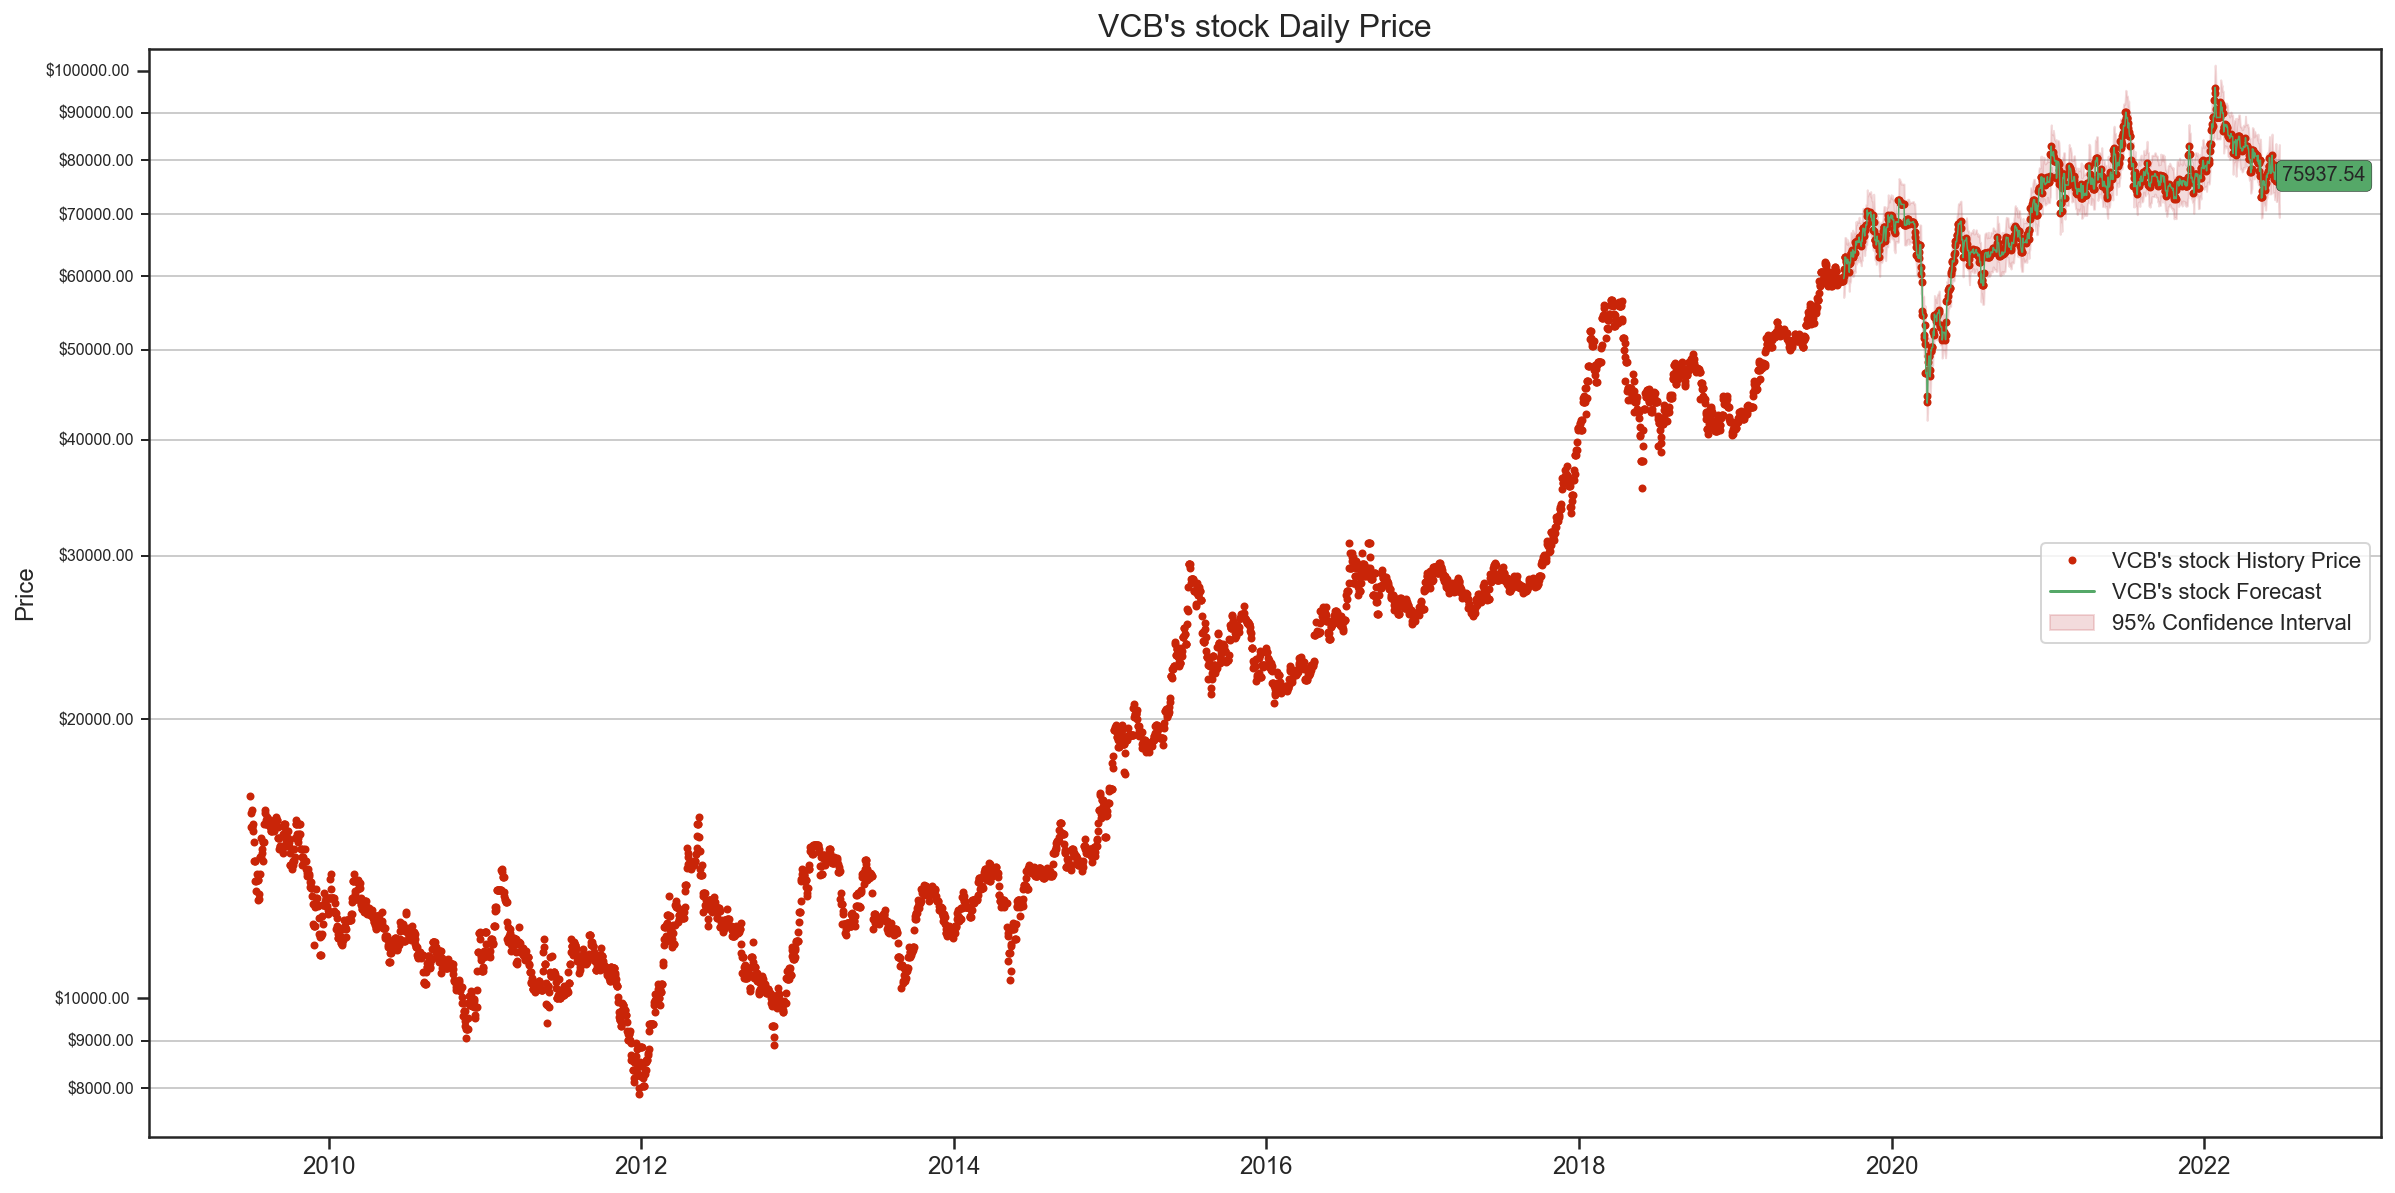

In [18]:
render_results(d_df, params=(0, 1, 1))